In [1]:
from utils_v1 import *


In [2]:
from icecream import ic
import pdb
from sklearn import metrics
import importlib
import utils_v1
import pathlib
import cv2
import sys
import numpy as np
from src import metrics as _metrics
from src.dataset import (
    Para, ParaDeforestationTime, ParaDistanceMap, ParaMultipleDates,
    MT, MTDeforestationTime, MTMultipleDates
)
from src import training_generator as generator
from src.patchesHandler import PatchesHandler, PatchesHandlerMultipleDates


In [3]:
# dataset = ParaDeforestationTime()
addPastDeforestationInput = True
dataset = ParaMultipleDates(dates = [2018, 2019], # dates = [2017, 2018, 2019]. [2018, 2019]. [2015, 2016, 2017, 2018]
	addPastDeforestationInput = addPastDeforestationInput,
	borderBuffer = 2)
dataset = MTDeforestationTime()

# dataset = MT()
# [2016, 2017, 2018]
# dataset = Para()
if type(dataset) != ParaMultipleDates and  type(dataset) != MTMultipleDates:
	patchesHandler = PatchesHandler()
else:
	patchesHandler = PatchesHandlerMultipleDates(
		dataset)

training = True
save_probabilities = False
loadInference = False
if training == False:
	if type(dataset) == Para:
		exp = 2

	if type(dataset) == ParaDeforestationTime:
		# exp = 3 # uses past deforestation mask until 2020, which is a mistake. use it until 2018
		exp = 4 # uses past deforestation mask without dates.
		exp = 5 # uses past deforestation mask with dates. 38 epochs.
		exp = 5 # fixes mask.
		exp = 6 # uses past deforestation distance and past deforestation. didnt test it yet        
		exp = 8 # Uses fixed past deforestation distance and past deforestation. 98.9 mAP
		exp = 9 # dummy for coords. high mAP. 99.8.   
		exp = 10 # using fixed fixed past deforestation distance. mAP 90.7   
		exp = 12 # Multiple dates. using fixed fixed past deforestation distance. mAP reduced to 89.6
	if type(dataset) == ParaDistanceMap:
		exp = 7 # not so good result.
	if type(dataset) == ParaMultipleDates:
		exp = 11 # Multiple dates. using fixed fixed past deforestation distance
		exp = 22
		exp = 50
		exp = 52
		# exp = 54
		exp = 56
		exp = 58
		# exp = 63
		# exp = 52
		# exp = 64
		# exp = 66
		exp = 66
		exp = 68
		# exp = 69
		# exp = 70
		exp = 72
	if type(dataset) == MTDeforestationTime:
		exp = 28
		exp = 78
		exp = 79 # good

else:
	exp = 13 # Multiple dates. using fixed fixed past deforestation distance
	
	exp = 80

ic| list(self.date_ids): [0]
ic| self.image_channels: [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]]


In [4]:
figures_path = 'figures' + dataset.__class__.__name__ + '/'
pathlib.Path(figures_path).mkdir(parents=True, exist_ok=True)
title_name = 'ResUnet'

In [5]:
# ic(type(dataset), exp, dataset.dates)


In [6]:
# Loading reference
label_mask = dataset.loadLabel()
print('Mask label shape: ', '\n', label_mask.shape, '\n', 'Unique values: ', '\n', np.unique(label_mask))

D:/Jorge/datasets/deforestation/MT/deforestation_before_2008/deforestation_before_2008_MT.tif
Mask label shape:  
 (16795, 10420) 
 Unique values:  
 [0 1 2]


In [7]:
# np.save('label_not_independent.npy', label_mask)


In [8]:
# Creating tile mask

mask_tiles = create_mask(label_mask.shape[0], label_mask.shape[1], 
        grid_size=(dataset.grid_x, dataset.grid_y))
label_mask = label_mask[:mask_tiles.shape[0], :mask_tiles.shape[1]]

Tiles size:  3359 2084
Mask size:  (16795, 10420)


In [9]:
label_mask.dtype

dtype('uint8')

In [10]:
label_mask_current_deforestation = dataset.getLabelCurrentDeforestation(
        label_mask)

In [11]:
label_mask.dtype

dtype('uint8')

In [12]:
# Loading image stack
image_stack = dataset.loadInputImage()

print('Image shape: ', image_stack.shape)
channels = image_stack.shape[-1]
image_stack = image_stack[:mask_tiles.shape[0], :mask_tiles.shape[1],:]
print('mask: ',mask_tiles.shape)
print('image stack: ', image_stack.shape)
print('ref :', label_mask.shape)
#plt.imshow(mask_tiles)

ic| np.unique(deforestation_time, return_counts=True): (array([0.        , 0.07692308, 0.15384616, 0.23076925, 0.30769232,
                                                              0.3846154 , 0.4615385 , 0.53846157, 0.61538464, 0.6923077 ,
                                                              0.7692308 , 0.84615386, 0.923077  , 1.        ], dtype=float32),
                                                        array([112663205,   2051611,   1054095,   1098902,   1007787,    876898,
                                                                 648966,    708580,    287191,    313901,    338545,    240796,
                                                                1332783,  52380640], dtype=int64))
ic| deforestation_time.shape: (16795, 10420, 1)
    image_stack.shape: (16795, 10420, 20)
ic| image_stack.shape: (16795, 10420, 21)


Image shape:  (16795, 10420, 21)
mask:  (16795, 10420)
image stack:  (16795, 10420, 21)
ref : (16795, 10420)


In [13]:
ic(image_stack.shape)
channels = image_stack.shape[-1]
ic(channels)

ic| image_stack.shape: (16795, 10420, 21)
ic| channels: 21


21

In [14]:
mask_tr_val, mask_amazon_ts = dataset.getTrainValTestMasks(mask_tiles)


Training tiles:  [2, 4, 5, 6, 7, 12, 14, 15, 18, 21, 23, 24]
Validation tiles:  [9, 11, 25]
Test tiles:  [1, 3, 8, 10, 13, 16, 17, 19, 20, 22]


In [15]:

patch_size = 128
if training == True:

    # Extracting patches from the idx matrix
    overlap = 0.7
    batch_size = 32
    im_idx = patchesHandler.create_idx_image(label_mask)


ic| im_idx_row.shape: (16795, 10420, 1)
    im_idx_col.shape: (16795, 10420, 1)
ic| im_idx_row.dtype: dtype('uint16')
    im_idx_col.dtype: dtype('uint16')
ic| im_idx.shape: (16795, 10420, 2), im_idx.dtype: dtype('uint16')


In [16]:
import importlib
if training == True:
	coords = patchesHandler.extract_patches(
		im_idx, patch_size=(patch_size, patch_size, 2), 
		overlap=overlap)

	coords_train, coords_val = patchesHandler.trainTestSplit(coords,
		mask_tr_val, patch_size=(patch_size, patch_size, 2))

	ic(coords_train.shape, coords_val.shape)
	# del im_idx

ic| coords.shape: (439, 271, 1, 128, 128, 2)
    coords.dtype: dtype('uint16')
ic| coords.shape: (118969, 2), coords.dtype: dtype('uint16')
ic| coords_train.shape: (54516, 2), coords_val.shape: (13175, 2)


In [17]:
label_mask.shape

(16795, 10420)

(-0.5, 10419.5, 16794.5, -0.5)

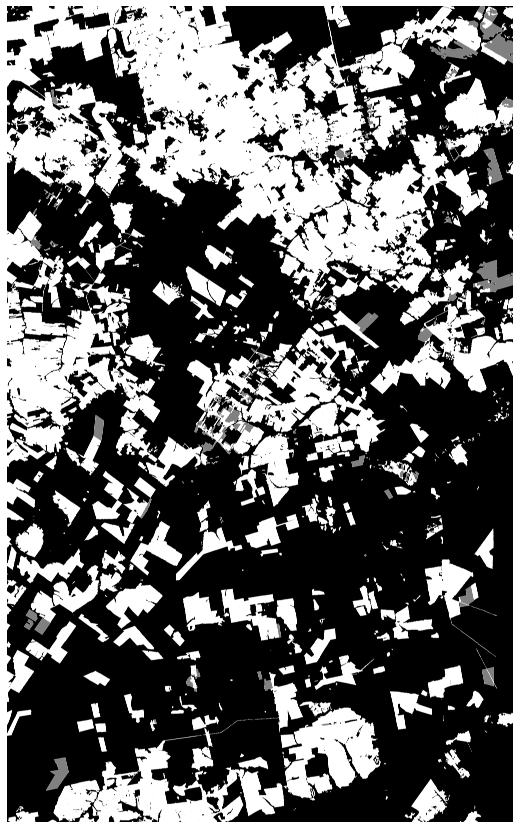

In [18]:

plt.figure(figsize=(15,15))
if type(dataset) != ParaDeforestationTime and type(dataset) != MTDeforestationTime and type(dataset) != MT:
    plt.imshow(label_mask[...,-1], cmap=plt.cm.gray)
else:
    plt.imshow(label_mask, cmap=plt.cm.gray)

# title_name = 'ResUnet'
plt.axis('off')
# plt.savefig('figures/Para' + title_name + ' error mask.png', dpi=150, bbox_inches='tight')

In [19]:
if training == True:
    print(coords_train)

[[    0  2090]
 [    0  2128]
 [    0  2166]
 ...
 [16644  8132]
 [16644  8170]
 [16644  8208]]


In [20]:
if training == True:

    # Keeping patches with 2% of def class
    coords_train = patchesHandler.retrieve_idx_percentage(label_mask, coords_train, 
			patch_size, pertentage = 0.2)
    coords_val = patchesHandler.retrieve_idx_percentage(label_mask, coords_val, 
			patch_size, pertentage = 0.2)
    print('training samples: ', coords_train.shape, 
			'validation samples: ', coords_val.shape)


training samples:  (3406, 2) validation samples:  (610, 2)


In [21]:
'''
import src.patchesHandler as sp
importlib.reload(sp)

patchesHandler = sp.PatchesHandlerMultipleDates(
		dataset)
'''

'\nimport src.patchesHandler as sp\nimportlib.reload(sp)\n\npatchesHandler = sp.PatchesHandlerMultipleDates(\n\t\tdataset)\n'

In [22]:
import src.plot as _plt
importlib.reload(_plt)

<module 'src.plot' from 'd:\\Jorge\\deforestation_uncertainty\\src\\plot.py'>

In [23]:
'''
if training == True:
    idx = 3100
    print(coords_train[idx])
    image_patch, reference_patch = patchesHandler.getPatch(
        image_stack, label_mask, coords_train, idx = idx)
    ic(np.mean(image_patch[...,[4,5,6]]), np.mean(image_patch[...,[14,15,16]]))
    _plt.plotCropSample5(image_stack[...,[4,5,6]], image_stack[...,[14,15,16]], 
            image_stack[...,[24,25,26]], image_stack[...,[34,35,36]],
            image_stack[...,[44,45,46]],            
            lims = None, 
            titles = ['2015', '2016', '2017', '2018', '2019'],
            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],
            maskBackground = [False, False, False, False, False],
            invertMask = [False, False, False, False, False])
'''

"\nif training == True:\n    idx = 3100\n    print(coords_train[idx])\n    image_patch, reference_patch = patchesHandler.getPatch(\n        image_stack, label_mask, coords_train, idx = idx)\n    ic(np.mean(image_patch[...,[4,5,6]]), np.mean(image_patch[...,[14,15,16]]))\n    _plt.plotCropSample5(image_stack[...,[4,5,6]], image_stack[...,[14,15,16]], \n            image_stack[...,[24,25,26]], image_stack[...,[34,35,36]],\n            image_stack[...,[44,45,46]],            \n            lims = None, \n            titles = ['2015', '2016', '2017', '2018', '2019'],\n            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],\n            maskBackground = [False, False, False, False, False],\n            invertMask = [False, False, False, False, False])\n"

In [24]:
'''
if training == True:
    idx = 3100
    print(coords_train[idx])
    image_patch, reference_patch = patchesHandler.getPatch(
        image_stack, label_mask, coords_train, idx = idx)
    ic(np.mean(image_patch[...,[1,2,3]]), np.mean(image_patch[...,[11,12,13]]))
    _plt.plotCropSample4(image_patch[...,[1,2,3]], image_patch[...,[11,12,13]], 
            reference_patch, reference_patch,
            lims = None, 
            titles = ['Optical T0', 'Optical T1', 'Reference', 'Reference 2'],
            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],
            maskBackground = [False, False, False, False],
            invertMask = [False, False, False, False])
'''

"\nif training == True:\n    idx = 3100\n    print(coords_train[idx])\n    image_patch, reference_patch = patchesHandler.getPatch(\n        image_stack, label_mask, coords_train, idx = idx)\n    ic(np.mean(image_patch[...,[1,2,3]]), np.mean(image_patch[...,[11,12,13]]))\n    _plt.plotCropSample4(image_patch[...,[1,2,3]], image_patch[...,[11,12,13]], \n            reference_patch, reference_patch,\n            lims = None, \n            titles = ['Optical T0', 'Optical T1', 'Reference', 'Reference 2'],\n            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],\n            maskBackground = [False, False, False, False],\n            invertMask = [False, False, False, False])\n"

In [25]:
'''
if training == True:

    idx = 6000
    print(coords_train[idx])
    image_patch, reference_patch = patchesHandler.getPatch(
        image_stack, label_mask, coords_train, idx = idx)
    ic(np.mean(image_patch[...,[1,2,3]]), np.mean(image_patch[...,[11,12,13]]))
    _plt.plotCropSample4(image_patch[...,[1,2,3]], image_patch[...,[11,12,13]], 
            reference_patch, reference_patch,
            lims = None, 
            titles = ['Optical T0', 'Optical T1', 'Reference', 'Reference 2'],
            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],
            maskBackground = [False, False, False, False],
            invertMask = [False, False, False, False])
'''

"\nif training == True:\n\n    idx = 6000\n    print(coords_train[idx])\n    image_patch, reference_patch = patchesHandler.getPatch(\n        image_stack, label_mask, coords_train, idx = idx)\n    ic(np.mean(image_patch[...,[1,2,3]]), np.mean(image_patch[...,[11,12,13]]))\n    _plt.plotCropSample4(image_patch[...,[1,2,3]], image_patch[...,[11,12,13]], \n            reference_patch, reference_patch,\n            lims = None, \n            titles = ['Optical T0', 'Optical T1', 'Reference', 'Reference 2'],\n            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],\n            maskBackground = [False, False, False, False],\n            invertMask = [False, False, False, False])\n"

In [26]:
'''
if training == True:

    idx = 97
    print(coords_train[idx])
    image_patch, reference_patch = patchesHandler.getPatch(
        image_stack, label_mask, coords_train, idx = idx)
    ic(np.mean(image_patch[...,[1,2,3]]), np.mean(image_patch[...,[11,12,13]]))
    _plt.plotCropSample4(image_patch[...,[1,2,3]], image_patch[...,[11,12,13]], 
            reference_patch, reference_patch,
            lims = None, 
            titles = ['Optical T0', 'Optical T1', 'Reference', 'Reference 2'],
            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],
            maskBackground = [False, False, False, False],
            invertMask = [False, False, False, False])

'''

"\nif training == True:\n\n    idx = 97\n    print(coords_train[idx])\n    image_patch, reference_patch = patchesHandler.getPatch(\n        image_stack, label_mask, coords_train, idx = idx)\n    ic(np.mean(image_patch[...,[1,2,3]]), np.mean(image_patch[...,[11,12,13]]))\n    _plt.plotCropSample4(image_patch[...,[1,2,3]], image_patch[...,[11,12,13]], \n            reference_patch, reference_patch,\n            lims = None, \n            titles = ['Optical T0', 'Optical T1', 'Reference', 'Reference 2'],\n            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],\n            maskBackground = [False, False, False, False],\n            invertMask = [False, False, False, False])\n\n"

In [27]:
'''
if training == True:

    idx = 1200
    print(coords_train[idx])
    image_patch, reference_patch = patchesHandler.getPatch(
        image_stack, label_mask, coords_train, idx = idx)
    ic(np.mean(image_patch[...,[1,2,3]]), np.mean(image_patch[...,[11,12,13]]))
    _plt.plotCropSample4(image_patch[...,[1,2,3]], image_patch[...,[11,12,13]], 
            reference_patch, reference_patch,
            lims = None, 
            titles = ['Optical T0', 'Optical T1', 'Reference', 'Reference 2'],
            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],
            maskBackground = [False, False, False, False],
            invertMask = [False, False, False, False])
'''

"\nif training == True:\n\n    idx = 1200\n    print(coords_train[idx])\n    image_patch, reference_patch = patchesHandler.getPatch(\n        image_stack, label_mask, coords_train, idx = idx)\n    ic(np.mean(image_patch[...,[1,2,3]]), np.mean(image_patch[...,[11,12,13]]))\n    _plt.plotCropSample4(image_patch[...,[1,2,3]], image_patch[...,[11,12,13]], \n            reference_patch, reference_patch,\n            lims = None, \n            titles = ['Optical T0', 'Optical T1', 'Reference', 'Reference 2'],\n            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],\n            maskBackground = [False, False, False, False],\n            invertMask = [False, False, False, False])\n"

In [28]:
'''
if training == True:

    idx = 3000
    print(coords_train[idx])
    image_patch, reference_patch = patchesHandler.getPatch(
        image_stack, label_mask, coords_train, idx = idx)
    ic(np.mean(image_patch[...,[1,2,3]]), np.mean(image_patch[...,[11,12,13]]))
    _plt.plotCropSample4(image_patch[...,[1,2,3]], image_patch[...,[11,12,13]], 
            reference_patch, reference_patch,
            lims = None, 
            titles = ['Optical T0', 'Optical T1', 'Reference', 'Reference 2'],
            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],
            maskBackground = [False, False, False, False],
            invertMask = [False, False, False, False])
'''

"\nif training == True:\n\n    idx = 3000\n    print(coords_train[idx])\n    image_patch, reference_patch = patchesHandler.getPatch(\n        image_stack, label_mask, coords_train, idx = idx)\n    ic(np.mean(image_patch[...,[1,2,3]]), np.mean(image_patch[...,[11,12,13]]))\n    _plt.plotCropSample4(image_patch[...,[1,2,3]], image_patch[...,[11,12,13]], \n            reference_patch, reference_patch,\n            lims = None, \n            titles = ['Optical T0', 'Optical T1', 'Reference', 'Reference 2'],\n            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],\n            maskBackground = [False, False, False, False],\n            invertMask = [False, False, False, False])\n"

In [29]:
'''
if training == True:

    idx = 6000
    print(coords_train[idx])
    image_patch, reference_patch = patchesHandler.getPatch(
        image_stack, label_mask, coords_train, idx = idx)
    ic(np.mean(image_patch[...,[1,2,3]]), np.mean(image_patch[...,[11,12,13]]))
    _plt.plotCropSample4(image_patch[...,[1,2,3]], image_patch[...,[11,12,13]], 
            reference_patch, reference_patch,
            lims = None, 
            titles = ['Optical T0', 'Optical T1', 'Reference', 'Reference 2'],
            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],
            maskBackground = [False, False, False, False],
            invertMask = [False, False, False, False])
'''

"\nif training == True:\n\n    idx = 6000\n    print(coords_train[idx])\n    image_patch, reference_patch = patchesHandler.getPatch(\n        image_stack, label_mask, coords_train, idx = idx)\n    ic(np.mean(image_patch[...,[1,2,3]]), np.mean(image_patch[...,[11,12,13]]))\n    _plt.plotCropSample4(image_patch[...,[1,2,3]], image_patch[...,[11,12,13]], \n            reference_patch, reference_patch,\n            lims = None, \n            titles = ['Optical T0', 'Optical T1', 'Reference', 'Reference 2'],\n            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],\n            maskBackground = [False, False, False, False],\n            invertMask = [False, False, False, False])\n"

In [30]:
# Creating train and validation data generator
# importlib.reload(patchesHandler)
import pdb
if training == True:

	train_datagen = ImageDataGenerator()
	valid_datagen = ImageDataGenerator()
	# pdb.set_trace()
	len_X_train = coords_train.shape[0]
	len_X_valid = coords_val.shape[0]

	train_gen = train_datagen.flow(
			np.expand_dims(np.expand_dims(coords_train, axis = -1), axis = -1), 
			np.expand_dims(np.expand_dims(coords_train, axis = -1), axis = -1),
			batch_size=batch_size,
			shuffle=True)
	# pdb.set_trace()

	valid_gen = valid_datagen.flow(
			np.expand_dims(np.expand_dims(coords_val, axis = -1), axis = -1), 
			np.expand_dims(np.expand_dims(coords_val, axis = -1), axis = -1),
			batch_size=batch_size,
			shuffle=False)

	number_class = 3
	train_gen_batch = patchesHandler.batch_generator(train_gen,
			image_stack, label_mask, patch_size, number_class)
	valid_gen_batch = patchesHandler.batch_generator(valid_gen,
			image_stack, label_mask, patch_size, number_class)

	#del image_stack

In [31]:
# Creating folder for the experiment

path_exp = dataset.paths.experiment + 'exp' + str(exp)
path_models = path_exp+'/models'
path_maps = path_exp+'/pred_maps'

if not os.path.exists(path_exp):
    os.makedirs(path_exp)   
if not os.path.exists(path_models):
    os.makedirs(path_models)   
if not os.path.exists(path_maps):
    os.makedirs(path_maps)
    
times = 1
method = 'resunet'
nb_filters = [16, 32, 64, 128, 256]
weights = [0.1, 0.9, 0]

In [32]:
if type(patchesHandler) == PatchesHandlerMultipleDates:
	channels = patchesHandler.input_image_shape

In [33]:
path_exp

'D:/Jorge/datasets/deforestation/experiments/MT/exp80'

In [34]:
channels

21

In [35]:
image_stack.shape

(16795, 10420, 21)

In [36]:

metrics_all = []
if training == True:
    for tm in range(0,times):
        print('time: ', tm)

        rows = patch_size
        cols = patch_size
        adam = Adam(lr = 1e-3 , beta_1=0.9)
        
        loss = weighted_categorical_crossentropy(weights)
        input_shape = (rows, cols, channels)
        model = build_resunet_dropout_spatial(input_shape, nb_filters, number_class)
        # model = build_resunet(input_shape, nb_filters, number_class)

        model.compile(optimizer=adam, loss=loss, metrics=['accuracy'])
        model.summary()

        earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10, verbose=1, mode='min')
        checkpoint = ModelCheckpoint(path_models+ '/' + method +'_'+str(tm)+'.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
        lr_reduce = ReduceLROnPlateau(factor=0.9, min_delta=0.0001, patience=5, verbose=1)
        callbacks_list = [earlystop, checkpoint]
        # train the model
        start_training = time.time()
        history = model.fit_generator(train_gen_batch,
                                steps_per_epoch=len_X_train*3//train_gen.batch_size,
                                validation_data=valid_gen_batch,
                                validation_steps=len_X_valid*3//valid_gen.batch_size,
                                epochs=100,
                                callbacks=callbacks_list)
        end_training = time.time() - start_training
        # metrics_all.append(end_training)
        del model, history

    # Saving training time
    # np.save(path_exp+'/metrics_tr.npy', metrics_all)
    del train_gen_batch, valid_gen_batch

time:  0


c:\Users\jchamorro\Anaconda3\envs\tf2\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_enc_net (InputLayer)      [(None, 128, 128, 21 0                                            
__________________________________________________________________________________________________
res1_net1 (Conv2D)              (None, 128, 128, 16) 3040        input_enc_net[0][0]              
__________________________________________________________________________________________________
drop_net1 (SpatialDropout2D)    (None, 128, 128, 16) 0           res1_net1[0][0]                  
__________________________________________________________________________________________________
res2_net1 (Conv2D)              (None, 128, 128, 16) 2320        drop_net1[0][0]                  
______________________________________________________________________________________________

c:\Users\jchamorro\Anaconda3\envs\tf2\lib\site-packages\tensorflow\python\keras\engine\training.py:1969: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


319/319 [==============================] - 24s 59ms/step - loss: 0.0841 - accuracy: 0.8155 - val_loss: 0.0260 - val_accuracy: 0.9285

Epoch 00001: val_loss improved from inf to 0.02602, saving model to D:/Jorge/datasets/deforestation/experiments/MT/exp80/models\resunet_0.h5
Epoch 2/100
  1/319 [..............................] - ETA: 17s - loss: 0.0991 - accuracy: 0.8375

c:\Users\jchamorro\Anaconda3\envs\tf2\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


319/319 [==============================] - 17s 54ms/step - loss: 0.0617 - accuracy: 0.8880 - val_loss: 0.0208 - val_accuracy: 0.9534

Epoch 00002: val_loss improved from 0.02602 to 0.02079, saving model to D:/Jorge/datasets/deforestation/experiments/MT/exp80/models\resunet_0.h5
Epoch 3/100
319/319 [==============================] - 17s 54ms/step - loss: 0.0562 - accuracy: 0.8992 - val_loss: 0.0196 - val_accuracy: 0.9598

Epoch 00003: val_loss improved from 0.02079 to 0.01960, saving model to D:/Jorge/datasets/deforestation/experiments/MT/exp80/models\resunet_0.h5
Epoch 4/100
319/319 [==============================] - 17s 54ms/step - loss: 0.0520 - accuracy: 0.9048 - val_loss: 0.0203 - val_accuracy: 0.9565

Epoch 00004: val_loss did not improve from 0.01960
Epoch 5/100
319/319 [==============================] - 17s 54ms/step - loss: 0.0484 - accuracy: 0.9108 - val_loss: 0.0179 - val_accuracy: 0.9621

Epoch 00005: val_loss improved from 0.01960 to 0.01791, saving model to D:/Jorge/datase

In [37]:
image_stack.shape

(16795, 10420, 21)

In [38]:
# patchesHandler.dataset.image_channels[-1]

In [39]:
if type(dataset) == ParaMultipleDates or type(dataset) == MTMultipleDates:
	channels = patchesHandler.input_image_shape
	image_stack = image_stack[..., patchesHandler.dataset.image_channels[-1]]
	label_mask = label_mask[...,-1]

In [40]:
image_stack.shape

(16795, 10420, 21)

In [41]:
#%% Test loop
times = 10

metrics_ts = []
n_pool = 3
n_rows = 5
n_cols = 4
rows, cols = image_stack.shape[:2]
pad_rows = rows - np.ceil(rows/(n_rows*2**n_pool))*n_rows*2**n_pool
pad_cols = cols - np.ceil(cols/(n_cols*2**n_pool))*n_cols*2**n_pool
print(pad_rows, pad_cols)

npad = ((0, int(abs(pad_rows))), (0, int(abs(pad_cols))), (0, 0))
image1_pad = np.pad(image_stack, pad_width=npad, mode='reflect')
del image_stack


-5.0 -12.0


In [42]:


h, w, c = image1_pad.shape
c = channels
patch_size_rows = h//n_rows
patch_size_cols = w//n_cols
num_patches_x = int(h/patch_size_rows)
num_patches_y = int(w/patch_size_cols)

ic(path_models+ '/' + method +'_'+str(0)+'.h5')
model = load_model(path_models+ '/' + method +'_'+str(0)+'.h5', compile=False)
class_n = 3

if loadInference == False:
    if save_probabilities == False:
        # prob_rec = np.zeros((image1_pad.shape[0],image1_pad.shape[1], class_n, times), dtype = np.float32)
        prob_rec = np.zeros((image1_pad.shape[0],image1_pad.shape[1], times), dtype = np.float32)

    metrics_all =[]
    with tf.device('/cpu:0'):
        for tm in range(0,times):
            print('time: ', tm)

            new_model = build_resunet_dropout_spatial(input_shape=(patch_size_rows,patch_size_cols, c), 
                nb_filters = nb_filters, n_classes = class_n)
            # new_model = build_resunet(input_shape=(patch_size_rows,patch_size_cols, c), 
            #     nb_filters = nb_filters, n_classes = class_n)

            for l in range(1, len(model.layers)):
                new_model.layers[l].set_weights(model.layers[l].get_weights())
            
            
            
            # Recinstructing predicted map
            start_test = time.time()

            prob_reconstructed = patchesHandler.infer(
                    new_model, image1_pad, h, w, 
                    num_patches_x, num_patches_y, patch_size_rows, 
                    patch_size_cols)
            ts_time =  time.time() - start_test

            if save_probabilities == True:
                np.save(path_maps+'/'+'prob_'+str(tm)+'.npy',prob_reconstructed) 
            else:
                prob_rec[:,:,tm] = prob_reconstructed
            
            metrics_all.append(ts_time)
            del prob_reconstructed
        metrics_ = np.asarray(metrics_all)
        # Saving test time
        np.save(path_exp+'/metrics_ts.npy', metrics_)


ic| path_models+ '/' + method +'_'+str(0)+'.h5': 'D:/Jorge/datasets/deforestation/experiments/MT/exp80/models/resunet_0.h5'


time:  0
time:  1
time:  2
time:  3
time:  4
time:  5
time:  6
time:  7
time:  8
time:  9


In [43]:
'''
with tf.device('/cpu:0'):
    for tm in range(0,times):
        np.save(path_maps+'/'+'prob_'+str(tm)+'.npy',prob_rec[:,:,tm]) 
'''

"\nwith tf.device('/cpu:0'):\n    for tm in range(0,times):\n        np.save(path_maps+'/'+'prob_'+str(tm)+'.npy',prob_rec[:,:,tm]) \n"

In [44]:
del image1_pad


In [45]:
# if loadInference == True:
if save_probabilities == True:
    prob_rec = np.zeros((h, w, times), dtype = np.float32)

    for tm in range (0, times):
        print(tm)
        prob_rec[:,:,tm] = np.load(path_maps+'/'+'prob_'+str(tm)+'.npy').astype(np.float32)

mean_prob = np.mean(prob_rec, axis = -1)
# np.save(path_maps+'/prob_mean.npy', mean_prob)



In [46]:
ic(mean_prob.shape)

ic| mean_prob.shape: (16800, 10432)


(16800, 10432)

In [47]:
# Computing metrics over the test tiles
mean_prob = mean_prob[:label_mask.shape[0], :label_mask.shape[1]]
'''
ref1 = np.ones_like(label_mask).astype(np.float32)

ref1 [label_mask == 2] = 0
TileMask = mask_amazon_ts * ref1
GTTruePositives = label_mask==1
'''


'\nref1 = np.ones_like(label_mask).astype(np.float32)\n\nref1 [label_mask == 2] = 0\nTileMask = mask_amazon_ts * ref1\nGTTruePositives = label_mask==1\n'

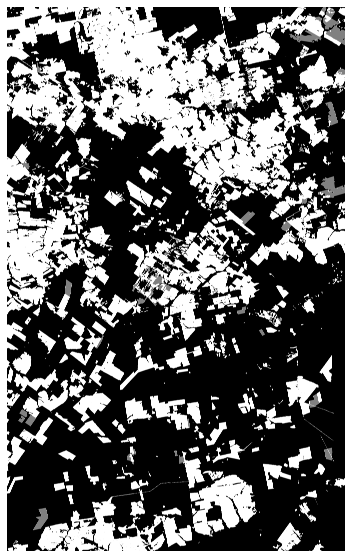

In [48]:
fig1 = plt.figure(figsize=(10,10))
plt.imshow(label_mask, cmap = plt.cm.gray)
plt.axis('off')
plt.savefig('figures/Para prediction probability.png', dpi=150, bbox_inches='tight')

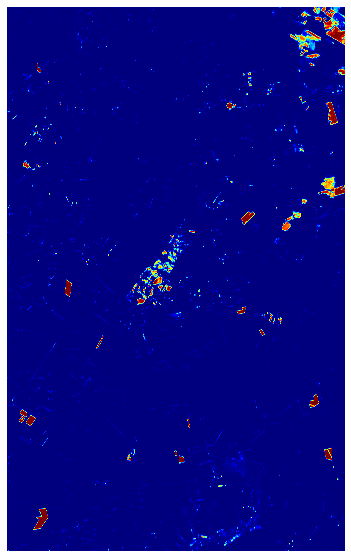

In [49]:
mean_prob = mean_prob.copy()
mean_prob[label_mask == 2] = 0
fig1 = plt.figure(figsize=(10,10))
plt.imshow(mean_prob, cmap = 'jet')
plt.axis('off')
plt.savefig('figures/Para prediction probability.png', dpi=150, bbox_inches='tight')

In [50]:
# print(np.unique(label_mask, return_counts=True))
print(label_mask.shape)

(16795, 10420)


In [51]:
label_test = label_mask[mask_amazon_ts == 1]
mean_prob_test = mean_prob[mask_amazon_ts == 1]
mean_prob_test = mean_prob_test[label_test != 2]
label_test = label_test[label_test != 2]

print(label_test.shape)
print(np.unique(label_test, return_counts=True))

(44666931,)
(array([0, 1], dtype=uint8), array([43791579,   875352], dtype=int64))


In [52]:
from sklearn import metrics
mAP = round(metrics.average_precision_score(label_test, 
        mean_prob_test)*100, 2)
print(mAP)

90.51


In [53]:
from icecream import ic

ic(prob_rec.shape)
prob_rec = np.transpose(prob_rec, (2, 0, 1))


ic| prob_rec.shape: (16800, 10432, 10)


In [54]:
prob_rec = np.expand_dims(prob_rec, axis = -1)

In [55]:
ic(prob_rec.shape)

ic| prob_rec.shape: (10, 16800, 10432, 1)


(10, 16800, 10432, 1)

In [56]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

epsilon = 1e-15
def show_im(im, ax, title = "", cmap = "jet"):
    im_plt = ax.imshow(im.astype(np.float32), cmap = cmap)
    plt.title(title)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im_plt, cax=cax) 

def get_mean(pred_probs):
      return np.mean(pred_probs, axis=0)
    
def get_uncertainty_var(pred_probs):
    return np.var(pred_probs, axis=0)
    
def predictive_variance(pred_probs):
    pred_var = get_uncertainty_var(pred_probs)
    pred_var = np.average(pred_var, axis = -1)
#    ic(pred_var.shape)
    return pred_var

def predictive_entropy(pred_probs):
    pred_mean = get_mean(pred_probs) # shape (patch_len, patch_len, class_n)
    pred_entropy = np.zeros((pred_mean.shape[0:2]))

    K = pred_mean.shape[-1]
    for k in range(K):
        pred_entropy = pred_entropy + pred_mean[..., k] * np.log(pred_mean[..., k] + epsilon) 
    pred_entropy = - pred_entropy / K
    return pred_entropy


def single_experiment_entropy(pred_prob):
    pred_entropy = np.zeros(pred_prob.shape[0:2])
    ic(pred_entropy.shape)
    
    K = pred_prob.shape[-1]
    for k in range(K):
        pred_entropy = pred_entropy + pred_prob[..., k] * np.log(pred_prob[..., k] + epsilon) 
    pred_entropy = - pred_entropy / K
    return pred_entropy

def mutual_information(pred_probs):
    H = predictive_entropy(pred_probs)
    sum_entropy = 0

    n = pred_probs.shape[0]
    K = pred_probs.shape[-1]
    ic(n, K)

    for i in range(n):
        for k in range(K):
            sum_entropy = sum_entropy + pred_probs[i, ..., k] * np.log(pred_probs[i, ..., k] + epsilon)

    sum_entropy = - sum_entropy / (n * K)

    MI = H - sum_entropy
    return MI

In [57]:
ic(np.min(prob_rec), np.mean(prob_rec), np.max(prob_rec))
ic(prob_rec.shape)

ic| np.min(prob_rec): 0.0
    np.mean(prob_rec): 0.016637513
    np.max(prob_rec): 1.0
ic| prob_rec.shape: (10, 16800, 10432, 1)


(10, 16800, 10432, 1)

In [58]:
pred_entropy = predictive_entropy(prob_rec).astype(np.float32)
pred_entropy_to_show = pred_entropy.copy()[:label_mask.shape[0], :label_mask.shape[1]]

pred_entropy_to_show[label_mask == 2] = 0



In [59]:
ic(np.min(pred_entropy_to_show), np.mean(pred_entropy_to_show), np.max(pred_entropy_to_show))
ic(np.min(pred_entropy), np.mean(pred_entropy), np.max(pred_entropy))
ic(pred_entropy.shape, pred_entropy_to_show.shape)

ic| np.min(pred_entropy_to_show): 0.0
    np.mean(pred_entropy_to_show): 0.008986436
    np.max(pred_entropy_to_show): 0.36787948
ic| np.min(pred_entropy): -0.0
    np.mean(pred_entropy): 0.009826789
    np.max(pred_entropy): 0.36787948
ic| pred_entropy.shape: (16800, 10432)
    pred_entropy_to_show.shape: (16795, 10420)


((16800, 10432), (16795, 10420))

In [60]:
prob_rec.shape

(10, 16800, 10432, 1)

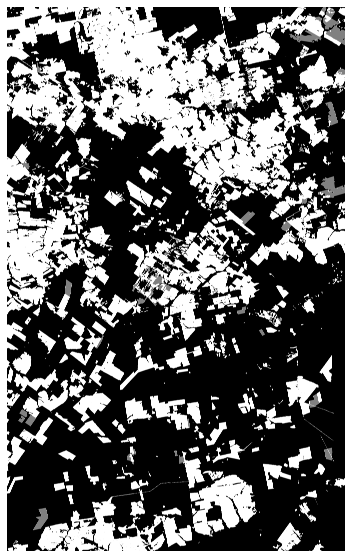

In [61]:
fig1 = plt.figure(figsize=(10,10))
plt.imshow(label_mask, cmap = plt.cm.gray)
plt.axis('off')
plt.savefig('figures/Para prediction probability.png', dpi=150, bbox_inches='tight')

In [62]:
# Computing error mask
# label_mask
'''
for idx in range(10):
    fig, ax = plt.subplots(figsize=(10,10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(prob_rec[idx], cmap = 'jet')
# fig.savefig('figures/Para' + title_name + ' reference.png', dpi=300, bbox_inches='tight')
'''

"\nfor idx in range(10):\n    fig, ax = plt.subplots(figsize=(10,10))\n    ax.set_xticks([])\n    ax.set_yticks([])\n    ax.imshow(prob_rec[idx], cmap = 'jet')\n# fig.savefig('figures/Para' + title_name + ' reference.png', dpi=300, bbox_inches='tight')\n"

(-0.5, 10419.5, 16794.5, -0.5)

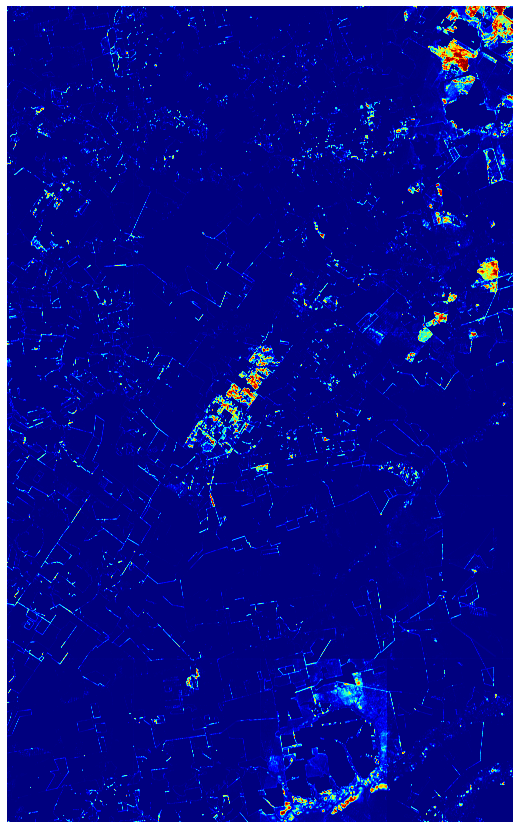

In [63]:
fig, ax = plt.subplots(figsize=(15,15))
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(pred_entropy_to_show, cmap='jet')
# show_im(pred_entropy_to_show, ax, title = 'Uncertainty predictive entropy')
plt.axis('off')
#plt.savefig('figures/Para' + title_name + ' uncertainty predictive entropy.png', 
 #   dpi=150, bbox_inches='tight')

In [64]:
ic(pred_entropy.shape)


ic| pred_entropy.shape: (16800, 10432)


(16800, 10432)

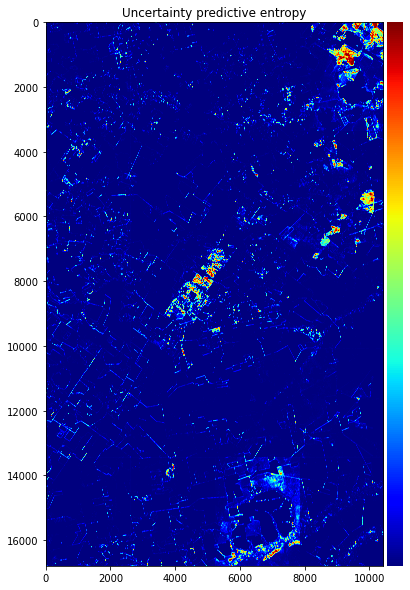

In [65]:

# pred_entropy_to_show = pred_entropy[:label_mask.shape[0], :label_mask.shape[1]].copy()

# ic(np.min(pred_entropy_to_show), np.mean(pred_entropy_to_show), np.max(pred_entropy_to_show))

# pred_entropy_to_show[label_mask == 2] = 0
fig, ax = plt.subplots(1,1,figsize=(10,10))
show_im(pred_entropy_to_show, ax, title = 'Uncertainty predictive entropy')
plt.axis('off')
plt.savefig('figures/Para' + title_name + ' uncertainty predictive entropy.png', 
    dpi=150, bbox_inches='tight')

In [66]:
ic(prob_rec.shape)
ic(np.min(prob_rec), np.mean(prob_rec), np.max(prob_rec))


ic| prob_rec.shape: (10, 16800, 10432, 1)
ic| np.min(prob_rec): 0.0
    np.mean(prob_rec): 0.016637513
    np.max(prob_rec): 1.0


(0.0, 0.016637513, 1.0)

In [67]:

'''
pred_entropy_single = single_experiment_entropy(prob_rec[0])

fig, ax = plt.subplots(1,1,figsize=(10,10))
show_im(pred_entropy_single, ax, title = 'Uncertainty predictive entropy single sample')
'''


"\npred_entropy_single = single_experiment_entropy(prob_rec[0])\n\nfig, ax = plt.subplots(1,1,figsize=(10,10))\nshow_im(pred_entropy_single, ax, title = 'Uncertainty predictive entropy single sample')\n"

In [68]:

'''
MI = mutual_information(prob_rec)

fig, ax = plt.subplots(1,1,figsize=(10,10))
show_im(MI, ax, title = 'Uncertainty MI')
'''


"\nMI = mutual_information(prob_rec)\n\nfig, ax = plt.subplots(1,1,figsize=(10,10))\nshow_im(MI, ax, title = 'Uncertainty MI')\n"

(array([0, 1, 2], dtype=uint8), array([70001560, 84001872, 21000468], dtype=int64))


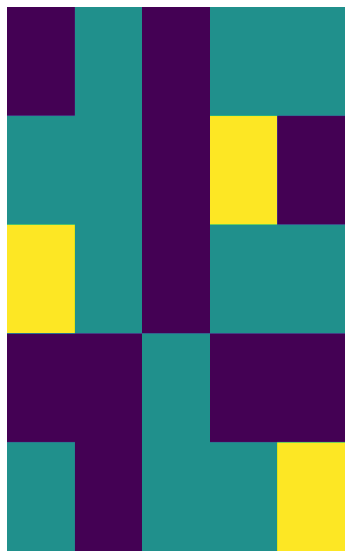

In [69]:
# mask_tr_val = test 0, train 1, val 2. 
# mask_ts = test 1.
print(np.unique(mask_tr_val, return_counts=True))
plt.figure(figsize=(10,10))
plt.imshow(mask_tr_val)
plt.axis('off')
plt.savefig('figures/Train val mask.png', dpi=200, bbox_inches='tight')



In [70]:
label_mask_current_deforestation = label_mask.copy()
label_mask_current_deforestation[label_mask_current_deforestation==2] = 0

In [71]:
label_mask_current_deforestation_to_show = label_mask_current_deforestation.copy()
label_mask_current_deforestation_to_show = np.abs(
        label_mask_current_deforestation_to_show - 1)
ic(np.unique(label_mask_current_deforestation_to_show, return_counts=True))

ic| np.unique(label_mask_current_deforestation_to_show, return_counts=True): (array([  0, 255], dtype=uint8), array([  2273209, 172730691], dtype=int64))


(array([  0, 255], dtype=uint8), array([  2273209, 172730691], dtype=int64))

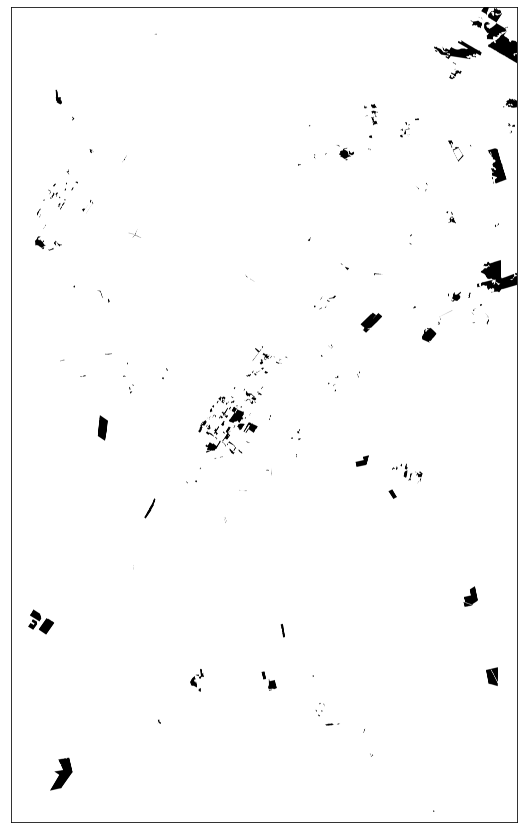

In [72]:
# Computing error mask
# label_mask

fig, ax = plt.subplots(figsize=(15,15))
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(label_mask_current_deforestation_to_show, cmap = plt.cm.gray)
fig.savefig('figures/Para' + title_name + ' reference.png', dpi=300, bbox_inches='tight')




In [73]:


label_mask_val = label_mask[mask_tr_val == 2]
ic(label_mask_val.shape)

mean_prob_val = mean_prob[mask_tr_val == 2]

mean_prob_val = mean_prob_val[label_mask_val != 2]
label_mask_val_valid = label_mask_val[label_mask_val != 2]
ic(label_mask_val_valid.shape)



ic| label_mask_val.shape: (21000468,)
ic| label_mask_val_valid.shape: (11808451,)


(11808451,)

In [74]:
from sklearn import metrics
pos_label = 1
precision, recall, thresholds = metrics.precision_recall_curve(
            label_mask_val_valid, mean_prob_val, pos_label=pos_label)



In [75]:
fscore = (2 * precision * recall) / (precision + recall)
ix = np.nanargmax(fscore)
best_threshold = thresholds[ix]
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))

Best Threshold=0.662723, F-Score=0.966


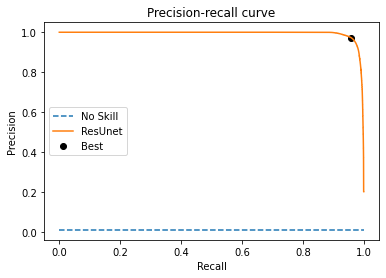

In [76]:
importlib.reload(_metrics)
_metrics.plotPrecisionRecall(label_mask_val, precision, recall, ix)
plt.savefig('figures/' + 'Para_prediction_recall_curve.png', dpi=150, bbox_inches='tight')

In [77]:
print(mean_prob.shape)
predicted = np.zeros_like(mean_prob)
threshold = 0.5
# threshold = best_threshold
# threshold = 0.46
# threshold = 0.57
# threshold = 0.5624
# threshold = 0.43
# threshold = 0.33
# threshold = 0.41
# threshold = 0.414413
# threshold = 0.507776
# threshold = 0.5622921
# threshold = 0.516014
# threshold = 0.405565
# threshold = 0.348671
# threshold = 0.394683
# threshold = 0.541279
# threshold = 0.420339

predicted[mean_prob>=threshold] = 1
predicted[mean_prob<threshold] = 0

print(np.unique(predicted, return_counts=True))

predicted_unpad = predicted.copy()
ic(predicted_unpad.shape, predicted.shape)
del predicted

(16795, 10420)


ic| predicted_unpad.shape: (16795, 10420)
    predicted.shape: (16795, 10420)


(array([0., 1.], dtype=float32), array([172542899,   2461001], dtype=int64))


In [78]:
threshold

0.5

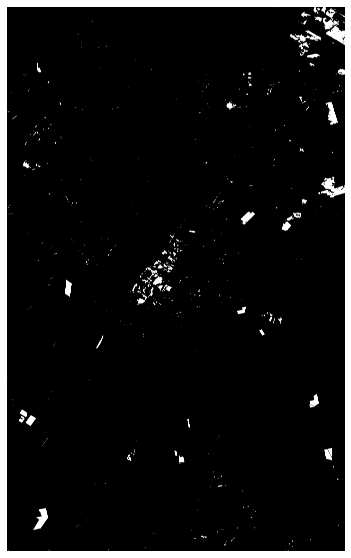

In [79]:

plt.figure(figsize=(10,10))
plt.imshow(predicted_unpad, cmap = plt.cm.gray)
plt.axis('off')
plt.savefig('figures/Para' + title_name + ' predicted.png', dpi=150, bbox_inches='tight')


In [80]:

# mean_prob_unpad = mean_prob[:-npad[0][1], :-npad[1][1]]

In [81]:
# mean_prob_unpad.shape

In [82]:
# ic(mask_amazon_ts.shape)
# mask_amazon_ts = mask_amazon_ts[:-npad[0][1], :-npad[1][1]]


In [83]:
# ic(mask_amazon_ts.shape, predicted_unpad.shape)
# label_mask_current_deforestation = label_mask_current_deforestation[:-npad[0][1], :-npad[1][1]]

In [84]:
# label_mask = label_mask[:-npad[0][1], :-npad[1][1]]

In [85]:
import importlib
import utils_v1
importlib.reload(utils_v1)

<module 'utils_v1' from 'd:\\Jorge\\deforestation_uncertainty\\utils_v1.py'>

In [86]:
ic(predicted_unpad.shape, label_mask_current_deforestation.shape,
    mask_amazon_ts.shape, label_mask.shape, mean_prob.shape)

ic| predicted_unpad.shape: (16795, 10420)
    label_mask_current_deforestation.shape: (16795, 10420)
    mask_amazon_ts.shape: (16795, 10420)
    label_mask.shape: (16795, 10420)
    mean_prob.shape: (16795, 10420)


((16795, 10420),
 (16795, 10420),
 (16795, 10420),
 (16795, 10420),
 (16795, 10420))

In [87]:
# test metrics
from sklearn.metrics import f1_score

predicted_test = predicted_unpad[mask_amazon_ts == 1]
label_mask_current_deforestation_test = label_mask_current_deforestation[mask_amazon_ts == 1]
label_mask_test = label_mask[mask_amazon_ts == 1]
mean_prob_test = mean_prob[mask_amazon_ts == 1]

ic(predicted_test.shape)

predicted_test = utils_v1.excludeBackgroundAreasFromTest(
        predicted_test, label_mask_test)
label_mask_current_deforestation_test = utils_v1.excludeBackgroundAreasFromTest(
        label_mask_current_deforestation_test, label_mask_test)
mean_prob_test = utils_v1.excludeBackgroundAreasFromTest(
        mean_prob_test, label_mask_test)

ic(predicted_test.shape)

deforestationMetricsGet = True
if deforestationMetricsGet == True:
        f1 = round(f1_score(label_mask_current_deforestation_test, predicted_test)*100, 2)
        precision = round(precision_score(label_mask_current_deforestation_test, predicted_test)*100, 2)
        recall = round(recall_score(label_mask_current_deforestation_test, predicted_test)*100, 2)

        mAP = round(metrics.average_precision_score(label_mask_current_deforestation_test, 
                mean_prob_test)*100, 2)


ic| predicted_test.shape: (70001560,)
ic| predicted_test.shape: (44666931,)


In [88]:
ic(f1, precision, recall, mAP)

ic| f1: 83.3, precision: 80.03, recall: 86.86, mAP: 90.51


(83.3, 80.03, 86.86, 90.51)

### Metrics for validation set in forest/deforestation detection

In [89]:
ic(mask_tr_val.shape)

ic| mask_tr_val.shape: (16795, 10420)


(16795, 10420)

In [90]:
predicted_val = predicted_unpad[mask_tr_val == 2]
predicted_val = predicted_val[label_mask_val != 2]

In [91]:

f1_val = round(f1_score(label_mask_val_valid, predicted_val)*100, 2)
precision_val = round(precision_score(label_mask_val_valid, predicted_val)*100, 2)
recall_val = round(recall_score(label_mask_val_valid, predicted_val)*100, 2)

mAP_val = round(metrics.average_precision_score(label_mask_val_valid, mean_prob_val)*100, 2)


ic(f1_val, precision_val, recall_val, mAP_val)

ic| f1_val: 95.96
    precision_val: 94.52
    recall_val: 97.44
    mAP_val: 99.39


(95.96, 94.52, 97.44, 99.39)

In [92]:

error_mask = np.abs(predicted_unpad - label_mask_current_deforestation)
print(np.unique(error_mask, return_counts=True))


(array([0., 1.], dtype=float32), array([174346616,    657284], dtype=int64))


In [93]:
false_positive_mask = predicted_unpad - label_mask_current_deforestation
ic(false_positive_mask.shape)
ic(np.unique(false_positive_mask, return_counts=True))
# 0 class 0, 1 class 1, 2 false positive, 3 false negative
# colormap black, white, blue, red.



ic| false_positive_mask.shape: (16795, 10420)
ic| np.unique(false_positive_mask, return_counts=True): (array([-1.,  0.,  1.], dtype=float32),
                                                         array([   234746, 174346616,    422538], dtype=int64))


(array([-1.,  0.,  1.], dtype=float32),
 array([   234746, 174346616,    422538], dtype=int64))

In [94]:
ic(predicted_unpad.shape, label_mask.shape)

ic| predicted_unpad.shape: (16795, 10420)
    label_mask.shape: (16795, 10420)


((16795, 10420), (16795, 10420))

In [95]:

importlib.reload(_metrics)

prediced_unpad_to_show = predicted_unpad.copy()
prediced_unpad_to_show[label_mask == 2] = 0

error_mask_to_show = _metrics.getRgbErrorMask(prediced_unpad_to_show, 
        label_mask_current_deforestation).astype(np.uint8)
error_mask_to_show_rgb = _metrics.saveRgbErrorMask(error_mask_to_show).astype(np.uint8)
del error_mask_to_show
cv2.imwrite('figures/Para_error_mask_to_show_rgb.png', error_mask_to_show_rgb)

# ,
#        dim = (617, 1162)


True

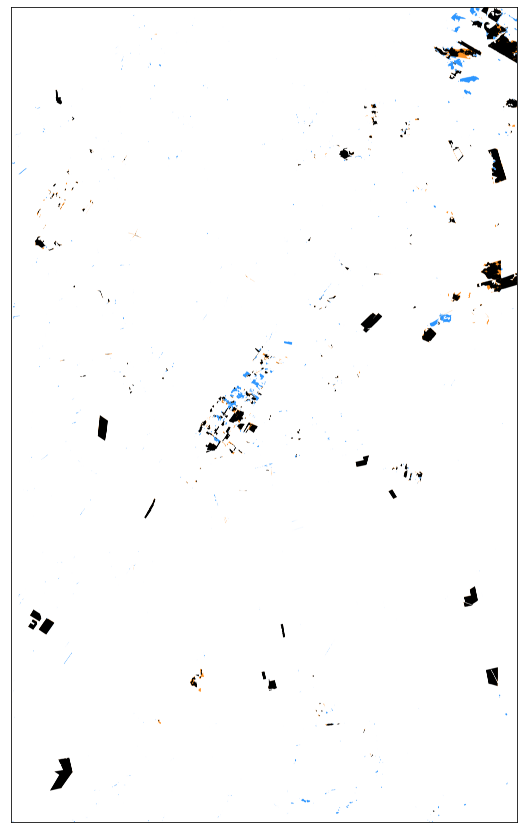

In [96]:
fig, ax = plt.subplots(figsize=(15,15))
ax.set_xticks([])
ax.set_yticks([])

ax.imshow(error_mask_to_show_rgb[...,::-1])

fig.savefig('figures/Para' + title_name + ' error mask color.png', dpi=300, bbox_inches='tight')


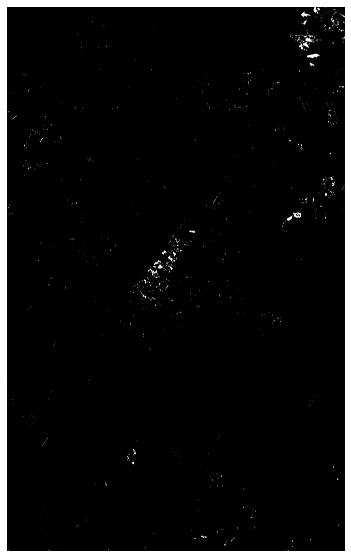

In [97]:
plt.figure(figsize=(10,10))
plt.imshow(error_mask, cmap=plt.cm.gray)
title_name = 'ResUnet'
plt.axis('off')
plt.savefig('figures/Para' + title_name + ' error mask.png', dpi=150, bbox_inches='tight')

In [98]:
ic(label_mask.shape)
ic(mask_amazon_ts.shape)
 
label_mask_test = utils_v1.getTestVectorFromIm(
        label_mask, mask_amazon_ts)        
ic(label_mask_test.shape)

error_mask_test = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
        error_mask, mask_amazon_ts),
        label_mask_test) 


error_mask_val = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
        error_mask, mask_tr_val, mask_return_value = 2),
        label_mask_val) 

 
ic(error_mask_test.shape)

ic| label_mask.shape: (16795, 10420)
ic| mask_amazon_ts.shape: (16795, 10420)
ic| label_mask_test.shape: (70001560,)
ic| error_mask_test.shape: (44666931,)


(44666931,)

In [99]:
# ic(pred_entropy[:-npad[0][1], :-npad[1][1]][:-npad[0][1], :-npad[1][1]].shape)

In [100]:
     

ic(pred_entropy.shape, utils_v1.unpadIm(pred_entropy, npad).shape, 
    mask_amazon_ts.shape, label_mask_test.shape)
pred_entropy_test = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
                utils_v1.unpadIm(pred_entropy, npad), mask_amazon_ts),
        label_mask_test)
  

ic| pred_entropy.shape: (16800, 10432)
    utils_v1.unpadIm(pred_entropy, npad).shape: (16795, 10420)
    mask_amazon_ts.shape: (16795, 10420)
    label_mask_test.shape: (70001560,)


In [101]:
pred_entropy_val = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
                utils_v1.unpadIm(pred_entropy, npad), mask_tr_val, mask_return_value = 2),
        label_mask_val)

In [102]:
from enum import Enum
Predictor = Enum('Predictor', 'pred_var MI pred_entropy pred_entropy_single')
predictor = Predictor.pred_entropy
# predictor = Predictor.pred_var
# predictor = Predictor.pred_entropy_single
# predictor = Predictor.MI

if predictor == Predictor.pred_var:
    y_pred = pred_var_test
    y_pred_val = pred_var_val
    plot_lims = [[0, 0.38], [0, 2500]]
    title_name = 'Predictive Variance'
    best_threshold = 0.2
elif predictor == Predictor.MI:
    y_pred = MI_test
    y_pred_val = MI_val
    plot_lims = [[0, 0.38], [0, 2500]]
    title_name = 'Mutual Information'
    best_threshold = 0.2
elif predictor == Predictor.pred_entropy:
    y_pred = pred_entropy_test
    y_pred_val = pred_entropy_val
    plot_lims = [[0, 0.38], [0, 2500]]
    title_name = 'Predictive Entropy'
    best_threshold = 0.287
elif predictor == Predictor.pred_entropy_single:
    y_pred = pred_entropy_single_test
    y_pred_val = pred_entropy_single_val
    plot_lims = [[0, 0.38], [0, 2500]]
    title_name = 'Predictive Entropy Single'
    best_threshold = 0.287


In [103]:
ic(np.min(y_pred), np.mean(y_pred), np.max(y_pred))
ic(np.min(pred_entropy), np.mean(pred_entropy), np.max(pred_entropy))


ic| np.min(y_pred): -0.0
    np.mean(y_pred): 0.012088372
    np.max(y_pred): 0.36787948
ic| np.min(pred_entropy): -0.0
    np.mean(pred_entropy): 0.009826789
    np.max(pred_entropy): 0.36787948


(-0.0, 0.009826789, 0.36787948)

In [104]:

y_test = error_mask_test
y_val = error_mask_val

ic(y_test.shape, y_pred.shape)
pos_label = 1
ROCmode = 'val'
if ROCmode == 'test':
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=pos_label)
elif ROCmode == 'val':
    fpr, tpr, thresholds = metrics.roc_curve(y_val, y_pred_val, pos_label=pos_label)

roc_auc = metrics.auc(fpr, tpr)
ic(roc_auc)

ic| y_test.shape: (44666931,), y_pred.shape: (44666931,)
ic| roc_auc: 0.9914479671707338


0.9914479671707338

Best Threshold=0.069630, G-Mean=0.977


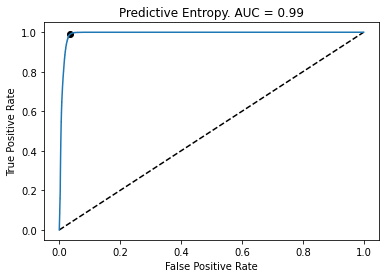

In [105]:
importlib.reload(_metrics)
plt.figure()
_metrics.plotAUC(fpr, tpr, roc_auc, modelId = title_name)
ix, best_threshold_uncertainty = _metrics.getBestThresholdGMean(fpr, tpr, thresholds)
# ix, best_threshold_uncertainty = _metrics.getBestThresholdJStatistic(fpr, tpr, thresholds)

_metrics.plotBestThreshold(fpr, tpr, ix)
plt.savefig(figures_path + title_name + ' roc_curve.png', dpi=200)

In [106]:
np.set_printoptions(suppress=False)
ic(best_threshold_uncertainty)
np.set_printoptions(suppress=True)


ic| best_threshold_uncertainty: 0.06963049


In [107]:
# best_threshold_uncertainty = 0.262948
# best_threshold_uncertainty = 0.08329400420188904

In [108]:
# threshold = 0.003254
y_pred_thresholded = np.zeros_like(y_pred)
y_pred_thresholded[y_pred >= best_threshold_uncertainty] = 1


In [109]:
metrics_error_detection = False
if metrics_error_detection == True:
    f1 = round(f1_score(error_mask_test, y_pred_thresholded)*100, 2)
    precision = round(metrics.precision_score(error_mask_test, y_pred_thresholded)*100, 2)
    recall = round(metrics.recall_score(error_mask_test, y_pred_thresholded)*100, 2)
    ic(f1, precision, recall)

    cm = metrics.confusion_matrix(error_mask_test, y_pred_thresholded)
    print(cm)

In [110]:
if metrics_error_detection == True:

    ic(best_threshold_uncertainty)

In [111]:
if metrics_error_detection == True:

    predicted_error_mask = np.zeros(pred_entropy.shape, dtype = np.uint8)
    predicted_error_mask[pred_entropy>=best_threshold_uncertainty] = 1
    predicted_error_mask = utils_v1.unpadIm(predicted_error_mask, npad)

    predicted_error_mask[label_mask == 2] = 0

In [112]:
if metrics_error_detection == True:

    # ic(np.unique(predicted_error_mask, return_counts=True))
    # ic(np.unique(error_mask, return_counts=True))
    predicted_error_mask_to_show = predicted_error_mask.copy()
    predicted_error_mask_to_show = np.abs(1 - predicted_error_mask_to_show)
    predicted_error_mask_to_show = predicted_error_mask_to_show.astype(np.uint8)*255
    predicted_error_mask_to_show = np.repeat(
        np.expand_dims(predicted_error_mask_to_show, axis=-1),
        3, axis = -1)
    fig, ax = plt.subplots(figsize=(15,15))
    ax.set_xticks([])
    ax.set_yticks([])

    ax.imshow(predicted_error_mask_to_show)


    title_name = 'ResUnet'
    fig.savefig('figures/Para' + title_name + 'predicted error mask.png', dpi=300, bbox_inches='tight')


In [113]:
if metrics_error_detection == True:

    predicted_error_mask_forest = predicted_error_mask.copy()
    predicted_error_mask_forest[predicted_unpad == 1] = 0
    ic(np.unique(predicted_unpad, return_counts=True))
    ic(np.unique(predicted_error_mask_forest, return_counts=True))

    plt.figure(figsize=(10,10))
    plt.imshow(predicted_error_mask, cmap=plt.cm.gray)
    title_name = 'ResUnet'
    plt.axis('off')
    plt.savefig('figures/Para' + title_name + 'predicted error mask forest.png', dpi=150, bbox_inches='tight')


In [114]:
if metrics_error_detection == True:

        importlib.reload(_metrics)
        _metrics.plotConfusionMatrix(cm)
        plt.savefig(figures_path + title_name + ' confusion matrix ROC threshold.png', 
                dpi=200, bbox_inches='tight')

In [115]:
label_mask_current_deforestation_test = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
                label_mask_current_deforestation, mask_amazon_ts),
        label_mask_test)

predicted_test = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
                predicted_unpad, mask_amazon_ts),
        label_mask_test)
        


Get precision-recall threshold

In [116]:
precision, recall, thresholds = metrics.precision_recall_curve(
            y_val, y_pred_val, pos_label=pos_label)



In [117]:
ic(thresholds)

ic| thresholds: array([0.02007507, 0.02007507, 0.02007507, ..., 0.36787942, 0.36787945,
                       0.36787948], dtype=float32)


array([0.02007507, 0.02007507, 0.02007507, ..., 0.36787942, 0.36787945,
       0.36787948], dtype=float32)

In [118]:
fscore = (2 * precision * recall) / (precision + recall)
ix = np.nanargmax(fscore)
best_threshold_uncertainty = thresholds[ix]
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))

Best Threshold=0.288990, F-Score=0.208


C:\Users\jchamorro\AppData\Local\Temp\ipykernel_22844\3129774117.py:1: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)


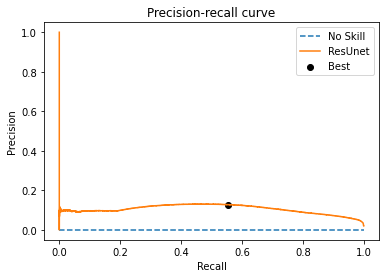

In [119]:
importlib.reload(_metrics)
_metrics.plotPrecisionRecall(y_val, precision, recall, ix)
plt.savefig('figures/' + 'Para' + 'prediction_recall_curve.png', dpi=150, bbox_inches='tight')

In [120]:
'''
# Metrics for th=0.5    
ProbList_05 = [0.5]

metrics_05 = matrics_AA_recall(ProbList_05, mean_prob, label_mask, mask_amazon_ts, 625)
print('Metrics th = 0.5: ', metrics_05*100)
'''


"\n# Metrics for th=0.5    \nProbList_05 = [0.5]\n\nmetrics_05 = matrics_AA_recall(ProbList_05, mean_prob, label_mask, mask_amazon_ts, 625)\nprint('Metrics th = 0.5: ', metrics_05*100)\n"

In [121]:
ic(np.min(y_pred), np.average(y_pred), np.max(y_pred))

ic| np.min(y_pred): -0.0
    np.average(y_pred): 0.012088372
    np.max(y_pred): 0.36787948


(-0.0, 0.012088372, 0.36787948)

(array([41956257.,   745315.,   369913.,   257799.,   210088.,   197612.,
          190320.,   185292.,   192361.,   361974.]),
 array([0.        , 0.03678795, 0.0735759 , 0.11036384, 0.1471518 ,
        0.18393974, 0.22072768, 0.25751564, 0.2943036 , 0.33109152,
        0.36787948], dtype=float32),
 <BarContainer object of 10 artists>)

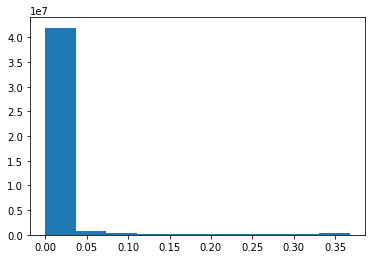

In [122]:
plt.hist(y_pred)

In [123]:
ic(y_pred.dtype, label_mask_current_deforestation_test.dtype, predicted_test.dtype)

ic| y_pred.dtype: dtype('float32')
    label_mask_current_deforestation_test.dtype: dtype('uint8')
    predicted_test.dtype: dtype('float32')


(dtype('float32'), dtype('uint8'), dtype('float32'))

In [124]:
ic(y_pred.shape, label_mask_current_deforestation_test.shape)
ic(np.unique(label_mask_current_deforestation_test))

ic| y_pred.shape: (44666931,)
    label_mask_current_deforestation_test.shape: (44666931,)
ic| np.unique(label_mask_current_deforestation_test): array([0, 1], dtype=uint8)


array([0, 1], dtype=uint8)

In [125]:
ic(np.min(y_pred), np.mean(y_pred), np.max(y_pred))

ic| np.min(y_pred): -0.0
    np.mean(y_pred): 0.012088372
    np.max(y_pred): 0.36787948


(-0.0, 0.012088372, 0.36787948)

In [126]:
importlib.reload(_metrics)

threshold_uncertainty = 0.15

predicted_thresholded = np.zeros_like(y_pred).astype(np.int8)
predicted_thresholded[y_pred >= threshold_uncertainty] = 1
predicted_thresholded = predicted_thresholded.astype(np.uint8)
ic(predicted_thresholded.shape)


ic| predicted_thresholded.shape: (44666931,)


(44666931,)

In [127]:
ic(np.unique(predicted_thresholded, return_counts=True),
    np.unique(label_mask, return_counts=True),
    np.unique(mask_amazon_ts, return_counts=True))



ic| np.unique(predicted_thresholded, return_counts=True): (array([0, 1], dtype=uint8), array([43346498,  1320433], dtype=int64))
    np.unique(label_mask, return_counts=True): (array([0, 1, 2], dtype=uint8),
                                                array([110023547,   2273209,  62707144], dtype=int64))
    np.unique(mask_amazon_ts, return_counts=True): (array([0, 1], dtype=uint8), array([105002340,  70001560], dtype=int64))


((array([0, 1], dtype=uint8), array([43346498,  1320433], dtype=int64)),
 (array([0, 1, 2], dtype=uint8),
  array([110023547,   2273209,  62707144], dtype=int64)),
 (array([0, 1], dtype=uint8), array([105002340,  70001560], dtype=int64)))

In [128]:
def getUncertaintyPercentageFromTest(uncertainty_mask, 
        label_mask, mask_test):
    total_test_area = mask_test.copy()
    total_test_area[label_mask == 2] = 0

    percentage = np.count_nonzero(uncertainty_mask.flatten()) / np.count_nonzero(total_test_area.flatten())
    return total_test_area, percentage

total_test_area, percentage = getUncertaintyPercentageFromTest(predicted_thresholded, 
        label_mask, mask_amazon_ts)

ic(percentage)

ic| percentage: 0.02956175789198501


0.02956175789198501

In [129]:
AA = np.count_nonzero(predicted_thresholded.flatten()) / len(label_mask_current_deforestation_test)
ic(AA)

# metrics_values = _metrics.getAA_Recall(y_pred, 
#                 label_mask_current_deforestation_test, 
#                 predicted_test, [threshold_uncertainty])


ic| AA: 0.02956175789198501


0.02956175789198501

In [130]:
importlib.reload(_metrics)

threshold_list = [0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.25, 0.27, 0.3, 0.34, 0.36]

loadThresholdMetrics = False
if loadThresholdMetrics == False:
        # threshold_list = [0.1]
        # y_test
        ic(y_pred.shape, label_mask_current_deforestation_test.shape)
        importlib.reload(_metrics)

        metrics_values = _metrics.getAA_Recall(y_pred, 
                label_mask_current_deforestation_test, 
                predicted_test, threshold_list)

        ic(metrics_values)



ic| y_pred.shape: (44666931,)
    label_mask_current_deforestation_test.shape: (44666931,)


threshold 0.01
(39914405,) (39914405,)
cm_correct [[39589248     6217]
 [    1974   316966]]


ic| label_current_deforestation_test_classified_incorrect.shape: (4752526,)
    predicted_test_classified_incorrect.shape: (4752526,)
ic| TP_H + FN_H + FP_H + TN_H: 4752526
    len(label_mask_current_deforestation_test): 44666931
ic| TP_H + FN_H + FP_H + TN_H: 4752526
    len(label_mask_current_deforestation_test): 44666931


cm_incorrect [[4012563  183551]
 [ 113075  443337]]
[0.98076322 0.99381075 0.36210119 0.10639921 0.70720288 0.79677829]
threshold 0.015
(40638712,) (40638712,)


ic| label_current_deforestation_test_classified_incorrect.shape: (4028219,)
    predicted_test_classified_incorrect.shape: (4028219,)


cm_correct [[40295117     6500]
 [    3155   333940]]


ic| TP_H + FN_H + FP_H + TN_H: 4028219
    len(label_mask_current_deforestation_test): 44666931
ic| TP_H + FN_H + FP_H + TN_H: 4028219
    len(label_mask_current_deforestation_test): 44666931


cm_incorrect [[3306694  183268]
 [ 111894  426363]]
[0.98090706 0.99064062 0.38149225 0.09018347 0.6993788  0.79211789]
threshold 0.025
(41441285,) (41441285,)


ic| label_current_deforestation_test_classified_incorrect.shape: (3225646,)
    predicted_test_classified_incorrect.shape: (3225646,)


cm_correct [[41072539     6918]
 [    5596   356232]]


ic| TP_H + FN_H + FP_H + TN_H: 3225646
    len(label_mask_current_deforestation_test): 44666931
ic| TP_H + FN_H + FP_H + TN_H: 3225646
    len(label_mask_current_deforestation_test): 44666931


cm_incorrect [[2529272  182850]
 [ 109453  404071]]
[0.98095002 0.98453409 0.40695857 0.07221553 0.68845892 0.78685904]
threshold 0.05
(42311457,) (42311457,)


ic| label_current_deforestation_test_classified_incorrect.shape: (2355474,)
    predicted_test_classified_incorrect.shape: (2355474,)


cm_correct [[41903946     7708]
 [    9271   390532]]


ic| TP_H + FN_H + FP_H + TN_H: 2355474
    len(label_mask_current_deforestation_test): 44666931
ic| TP_H + FN_H + FP_H + TN_H: 2355474
    len(label_mask_current_deforestation_test): 44666931


cm_incorrect [[1697865  182060]
 [ 105778  369771]]
[0.98064484 0.97681108 0.44614281 0.05273418 0.67008015 0.77756656]
threshold 0.08
(42780038,) (42780038,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1886893,)
    predicted_test_classified_incorrect.shape: (1886893,)


cm_correct [[42338521    10898]
 [   12930   417689]]


ic| TP_H + FN_H + FP_H + TN_H: 1886893
    len(label_mask_current_deforestation_test): 44666931
ic| TP_H + FN_H + FP_H + TN_H: 1886893
    len(label_mask_current_deforestation_test): 44666931


cm_incorrect [[1263290  178870]
 [ 102119  342614]]
[0.97457226 0.96997346 0.4771669  0.04224362 0.65699811 0.77038133]
threshold 0.1
(42982749,) (42982749,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1684182,)
    predicted_test_classified_incorrect.shape: (1684182,)
ic

cm_correct [[42516153    14897]
 [   14758   436941]]
cm_incorrect [[1085658  174871]
 [ 100291  323362]]


| TP_H + FN_H + FP_H + TN_H: 1684182
    len(label_mask_current_deforestation_test): 44666931
ic| TP_H + FN_H + FP_H + TN_H: 1684182
    len(label_mask_current_deforestation_test): 44666931


[0.96703022 0.9673278  0.49916034 0.03770534 0.64901763 0.76327088]
threshold 0.15
(43346498,) (43346498,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1320433,)
    predicted_test_classified_incorrect.shape: (1320433,)
ic| TP_H + FN_H + FP_H + TN_H: 1320433
    len(label_mask_current_deforestation_test): 44666931
ic| TP_H + FN_H + FP_H + TN_H: 1320433
    len(label_mask_current_deforestation_test): 44666931


cm_correct [[42799814    31390]
 [   18746   496548]]
cm_incorrect [[801997 158378]
 [ 96303 263755]]
[0.94054226 0.96362077 0.56725523 0.02956176 0.62481493 0.73253476]
threshold 0.2
(43626674,) (43626674,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1040257,)
    predicted_test_classified_incorrect.shape: (1040257,)
ic| TP_H + FN_H + FP_H + TN_H: 1040257
    len(label_mask_current_deforestation_test): 44666931
ic| TP_H + FN_H + FP_H + TN_H: 1040257
    len(label_mask_current_deforestation_test): 44666931


cm_correct [[42983306    55990]
 [   23216   564162]]
cm_incorrect [[618505 133778]
 [ 91833 196141]]
[0.90971568 0.9604752  0.6444973  0.0232892  0.59451259 0.68110663]
threshold 0.25
(43889032,) (43889032,)


ic| label_current_deforestation_test_classified_incorrect.shape: (777899,)
    predicted_test_classified_incorrect.shape: (777899,)
ic| TP_H + FN_H + FP_H + TN_H: 777899
    len(label_mask_current_deforestation_test): 44666931
ic| TP_H + FN_H + FP_H + TN_H: 777899
    len(label_mask_current_deforestation_test): 44666931


cm_correct [[43127085    91444]
 [   29234   641269]]
cm_incorrect [[474726  98324]
 [ 85815 119034]]
[0.87519807 0.9563999  0.73258415 0.01741555 0.5476403  0.58108167]
threshold 0.27
(43990684,) (43990684,)


ic| label_current_deforestation_test_classified_incorrect.shape: (676247,)
    predicted_test_classified_incorrect.shape: (676247,)
ic| TP_H + FN_H + FP_H + TN_H: 676247
    len(label_mask_current_deforestation_test): 44666931
ic| TP_H + FN_H + FP_H + TN_H: 676247
    len(label_mask_current_deforestation_test): 44666931


cm_correct [[43180079   107578]
 [   32314   670713]]
cm_incorrect [[421732  82190]
 [ 82735  89590]]
[0.86177664 0.9540359  0.7662209  0.01513977 0.52153918 0.51988974]
threshold 0.3
(44141517,) (44141517,)


ic| label_current_deforestation_test_classified_incorrect.shape: (525414,)
    predicted_test_classified_incorrect.shape: (525414,)
ic| TP_H + FN_H + FP_H + TN_H: 525414
    len(label_mask_current_deforestation_test): 44666931
ic| TP_H + FN_H + FP_H + TN_H: 525414
    len(label_mask_current_deforestation_test): 44666931


cm_correct [[43260287   133425]
 [   37944   709861]]
cm_incorrect [[341524  56343]
 [ 77105  50442]]
[0.84177966 0.9492595  0.81094348 0.01176293 0.47236971 0.39547775]
threshold 0.34
(44357478,) (44357478,)


ic| label_current_deforestation_test_classified_incorrect.shape: (309453,)
    predicted_test_classified_incorrect.shape: (309453,)
ic| TP_H + FN_H + FP_H + TN_H: 309453
    len(label_mask_current_deforestation_test): 44666931
ic| TP_H + FN_H + FP_H + TN_H: 309453
    len(label_mask_current_deforestation_test): 44666931


cm_correct [[43375668   179377]
 [   49464   752969]]
cm_incorrect [[226143  10391]
 [ 65585   7334]]
[0.80760683 0.93835747 0.86018996 0.00692801 0.41376587 0.10057735]
threshold 0.36
(44509116,) (44509116,)


ic| label_current_deforestation_test_classified_incorrect.shape: (157815,)
    predicted_test_classified_incorrect.shape: (157815,)
d:\Jorge\deforestation_uncertainty\src\metrics.py:257: RuntimeWarning: invalid value encountered in longlong_scalars
  precision_H = TP_H / (TP_H + FP_H)
ic| TP_H + FN_H + FP_H + TN_H: 157815
    len(label_mask_current_deforestation_test): 44666931
ic| TP_H + FN_H + FP_H + TN_H: 157815
    len(label_mask_current_deforestation_test): 44666931
ic| metrics_values: array([[0.98076322, 0.99381075, 0.36210119, 0.10639921, 0.70720288,
                            0.79677829],
                           [0.98090706, 0.99064062, 0.38149225, 0.09018347, 0.6993788 ,
                            0.79211789],
                           [0.98095002, 0.98453409, 0.40695857, 0.07221553, 0.68845892,
                            0.78685904],
                           [0.98064484, 0.97681108, 0.44614281, 0.05273418, 0.67008015,
                            0.77756656],
        

cm_correct [[43480906   189768]
 [   78139   760303]]
cm_incorrect [[120905      0]
 [ 36910      0]]
[0.80025914 0.90680453 0.8685683  0.00353315        nan 0.        ]


In [131]:

if loadThresholdMetrics == False:
        # threshold_list = [0.1]
        # y_test
        ic(y_pred.shape, label_mask_current_deforestation_test.shape)
        importlib.reload(_metrics)

        metric_values_audited = _metrics.getUncertaintyMetricsAudited(y_pred, 
                label_mask_current_deforestation_test, 
                predicted_test, threshold_list)

        ic(metric_values_audited)



ic| y_pred.shape: (44666931,)
    label_mask_current_deforestation_test.shape: (44666931,)


threshold 0.01
(44666931,) (44666931,)
cm_audited [[43785362     6217]
 [    1974   873378]]
[0.99293197 0.99774491]
threshold 0.015
(44666931,) (44666931,)
cm_audited [[43785079     6500]
 [    3155   872197]]
[0.99260268 0.99639574]
threshold 0.025
(44666931,) (44666931,)
cm_audited [[43784661     6918]
 [    5596   869756]]
[0.99210881 0.99360714]
threshold 0.05
(44666931,) (44666931,)
cm_audited [[43783871     7708]
 [    9271   866081]]
[0.99117865 0.98940883]
threshold 0.08
(44666931,) (44666931,)
cm_audited [[43780681    10898]
 [   12930   862422]]
[0.98752118 0.9852288 ]
threshold 0.1
(44666931,) (44666931,)
cm_audited [[43776682    14897]
 [   14758   860594]]
[0.98298441 0.9831405 ]
threshold 0.15
(44666931,) (44666931,)
cm_audited [[43760189    31390]
 [   18746   856606]]
[0.96465074 0.97858462]
threshold 0.2
(44666931,) (44666931,)
cm_audited [[43735589    55990]
 [   23216   852136]]
[0.93834556 0.9734781 ]
threshold 0.25
(44666931,) (44666931,)
cm_audited [[43700135    

ic| metric_values_audited: array([[0.99293197, 0.99774491],
                                  [0.99260268, 0.99639574],
                                  [0.99210881, 0.99360714],
                                  [0.99117865, 0.98940883],
                                  [0.98752118, 0.9852288 ],
                                  [0.98298441, 0.9831405 ],
                                  [0.96465074, 0.97858462],
                                  [0.93834556, 0.9734781 ],
                                  [0.90246618, 0.96660315],
                                  [0.88683338, 0.96308456],
                                  [0.86256648, 0.95665287],
                                  [0.82156247, 0.94349245],
                                  [0.80772882, 0.9107342 ]])


cm_audited [[43601811   189768]
 [   78139   797213]]
[0.80772882 0.9107342 ]


In [132]:
m_audited = {'precision': metric_values_audited[:,0],
        'recall': metric_values_audited[:,1]}



In [133]:
'''
threshold_list = [0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.25, 0.27, 0.3, 0.34]
importlib.reload(_metrics)

metrics = _metrics.getF1byThreshold(y_pred,
    error_mask, threshold_list)

ic(metrics)
'''

'\nthreshold_list = [0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.25, 0.27, 0.3, 0.34]\nimportlib.reload(_metrics)\n\nmetrics = _metrics.getF1byThreshold(y_pred,\n    error_mask, threshold_list)\n\nic(metrics)\n'

In [134]:
if loadThresholdMetrics == False:

    np.save('metrics.npy', metrics_values)
if loadThresholdMetrics == True:
    metrics_values = np.load('metrics.npy')


In [135]:
save_figures = True

In [136]:
m = {'precision_L': metrics_values[:,0],
        'recall_L': metrics_values[:,1],
        'recall_Ltotal': metrics_values[:,2],
        'AA': metrics_values[:,3],
        'precision_H': metrics_values[:,4],
        'recall_H': metrics_values[:,5]}



In [137]:
threshold_list = [0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.25, 0.27, 0.3, 0.34, 0.36]


In [138]:
# m['precision_H'] = np.nan_to_num(m['precision_H'], nan=0)

In [139]:
'''
m = {'precision_L': metrics[1:,0],
        'recall_L': metrics[1:,1],
        'recall_Ltotal': metrics[1:,2],
        'AA': metrics[1:,3],
        'precision_H': metrics[1:,4],
        'recall_H': metrics[1:,5]}

threshold_list = [0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.25, 0.27, 0.3, 0.34]
'''

"\nm = {'precision_L': metrics[1:,0],\n        'recall_L': metrics[1:,1],\n        'recall_Ltotal': metrics[1:,2],\n        'AA': metrics[1:,3],\n        'precision_H': metrics[1:,4],\n        'recall_H': metrics[1:,5]}\n\nthreshold_list = [0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.25, 0.27, 0.3, 0.34]\n"

In [140]:
'''
plt.plot(m['recall_L']*100, m['AA']*100)
plt.title('Recall vs. To-Audit Area')
plt.xlabel('Recall (%)')
plt.ylabel('Audit Area (%)')
if save_figures == True:
    plt.savefig('figures/recall_AA.png', dpi=150, bbox_inches='tight')
'''

"\nplt.plot(m['recall_L']*100, m['AA']*100)\nplt.title('Recall vs. To-Audit Area')\nplt.xlabel('Recall (%)')\nplt.ylabel('Audit Area (%)')\nif save_figures == True:\n    plt.savefig('figures/recall_AA.png', dpi=150, bbox_inches='tight')\n"

In [141]:
'''
plt.plot(m['precision_L']*100, m['AA']*100)
plt.title('Precision vs. To-Audit Area')
plt.xlabel('Precision (%)')
plt.ylabel('Audit Area (%)')
if save_figures == True:
    plt.savefig('figures/precision_AA.png', dpi=150, bbox_inches='tight')
'''

"\nplt.plot(m['precision_L']*100, m['AA']*100)\nplt.title('Precision vs. To-Audit Area')\nplt.xlabel('Precision (%)')\nplt.ylabel('Audit Area (%)')\nif save_figures == True:\n    plt.savefig('figures/precision_AA.png', dpi=150, bbox_inches='tight')\n"

In [142]:
'''
plt.plot(m['recall_Ltotal']*100, m['AA']*100)
plt.title('Recall total vs. To-Audit Area')
plt.xlabel('Recall (%)')
plt.ylabel('Audit Area (%)')
if save_figures == True:
    plt.savefig('figures/recall_total_AA.png', dpi=150, bbox_inches='tight')
'''

"\nplt.plot(m['recall_Ltotal']*100, m['AA']*100)\nplt.title('Recall total vs. To-Audit Area')\nplt.xlabel('Recall (%)')\nplt.ylabel('Audit Area (%)')\nif save_figures == True:\n    plt.savefig('figures/recall_total_AA.png', dpi=150, bbox_inches='tight')\n"

In [143]:
'''
plt.plot(m['recall_L']*100, np.asarray(threshold_list))
plt.title('Recall vs. Threshold')
plt.xlabel('Recall (%)')
plt.ylabel('Threshold')
if save_figures == True:
    plt.savefig('figures/recall_threshold.png', dpi=150, bbox_inches='tight')
'''

"\nplt.plot(m['recall_L']*100, np.asarray(threshold_list))\nplt.title('Recall vs. Threshold')\nplt.xlabel('Recall (%)')\nplt.ylabel('Threshold')\nif save_figures == True:\n    plt.savefig('figures/recall_threshold.png', dpi=150, bbox_inches='tight')\n"

In [144]:
'''
plt.plot(m['recall_Ltotal']*100, np.asarray(threshold_list))
plt.title('Recall total vs. Threshold')
plt.xlabel('Recall (%)')
plt.ylabel('Threshold')
if save_figures == True:
    plt.savefig('figures/recall_total_threshold.png', dpi=150, bbox_inches='tight')
'''

"\nplt.plot(m['recall_Ltotal']*100, np.asarray(threshold_list))\nplt.title('Recall total vs. Threshold')\nplt.xlabel('Recall (%)')\nplt.ylabel('Threshold')\nif save_figures == True:\n    plt.savefig('figures/recall_total_threshold.png', dpi=150, bbox_inches='tight')\n"

In [145]:
'''
plt.plot(m['precision_L']*100, np.asarray(threshold_list))
plt.title('Precision vs. Threshold')
plt.xlabel('Precision (%)')
plt.ylabel('Threshold')
if save_figures == True:
    plt.savefig('figures/precision_total_threshold.png', dpi=150, bbox_inches='tight')
'''

"\nplt.plot(m['precision_L']*100, np.asarray(threshold_list))\nplt.title('Precision vs. Threshold')\nplt.xlabel('Precision (%)')\nplt.ylabel('Threshold')\nif save_figures == True:\n    plt.savefig('figures/precision_total_threshold.png', dpi=150, bbox_inches='tight')\n"

In [146]:
'''
plt.plot(m['recall_L']*100, np.asarray(threshold_list))
plt.title('Audit area vs. Threshold')
plt.xlabel('Audit area (%)')
plt.ylabel('Threshold')
if save_figures == True:
    plt.savefig('figures/recall_threshold.png', dpi=150, bbox_inches='tight')
'''

"\nplt.plot(m['recall_L']*100, np.asarray(threshold_list))\nplt.title('Audit area vs. Threshold')\nplt.xlabel('Audit area (%)')\nplt.ylabel('Threshold')\nif save_figures == True:\n    plt.savefig('figures/recall_threshold.png', dpi=150, bbox_inches='tight')\n"

In [147]:
m['f1_L'] = 2*m['precision_L']*m['recall_L']/(m['precision_L']+m['recall_L'])
m['f1_H'] = 2*m['precision_H']*m['recall_H']/(m['precision_H']+m['recall_H'])

m_audited['f1'] = 2*m_audited['precision']*m_audited['recall']/(m_audited['precision']+m_audited['recall'])

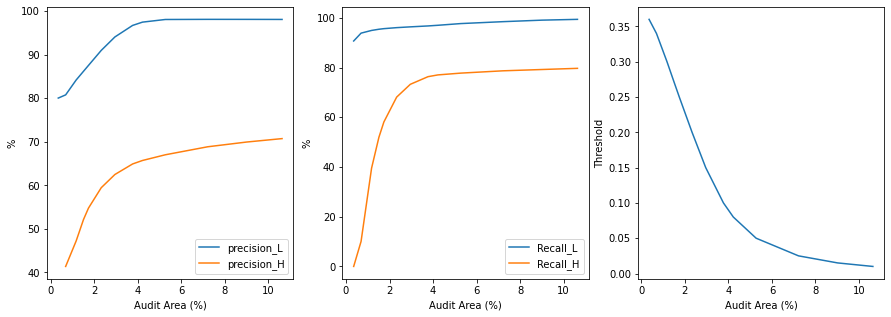

In [148]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figheight(5)
fig.set_figwidth(15)
ax1.plot(m['AA']*100, m['precision_L']*100, label="precision_L")
ax1.plot(m['AA']*100, m['precision_H']*100, label="precision_H")
ax1.legend(loc="lower right")
ax1.set_ylabel('%')
ax1.set_xlabel('Audit Area (%)')

ax2.plot(m['AA']*100, m['recall_L']*100, label="Recall_L")
ax2.plot(m['AA']*100, m['recall_H']*100, label="Recall_H")
ax2.legend(loc="lower right")
ax2.set_ylabel('%')
ax2.set_xlabel('Audit Area (%)')

ax3.plot(m['AA']*100, np.asarray(threshold_list), label="AA")
ax3.set_xlabel('Audit Area (%)')
ax3.set_ylabel('Threshold')

# if save_figures == True:
if True:
    plt.savefig('figures/recall_precision_AA.png', dpi=150, bbox_inches='tight')

In [149]:
xlim = [-0.3, 12.7]
ylim = [0, 105]


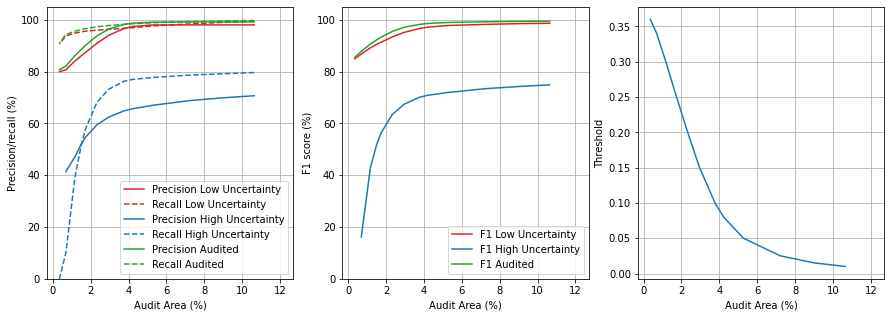

In [150]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figheight(5)
fig.set_figwidth(15)
ax1.plot(m['AA']*100, m['precision_L']*100, 'C3-', label="Precision Low Uncertainty")
ax1.plot(m['AA']*100, m['recall_L']*100, 'C3--', label="Recall Low Uncertainty")
ax1.plot(m['AA']*100, m['precision_H']*100, 'C0-', label="Precision High Uncertainty")
ax1.plot(m['AA']*100, m['recall_H']*100, 'C0--', label="Recall High Uncertainty")
ax1.plot(m['AA']*100, m_audited['precision']*100, 'C2-', label="Precision Audited")
ax1.plot(m['AA']*100, m_audited['recall']*100, 'C2--', label="Recall Audited")

ax1.legend(loc="lower right")
ax1.set_ylabel('Precision/recall (%)')
ax1.set_xlabel('Audit Area (%)')
ax1.set_ylim(ylim)
ax1.set_xlim(xlim)
ax1.grid()
ax2.plot(m['AA']*100, m['f1_L']*100, 'C3-', label="F1 Low Uncertainty")
ax2.plot(m['AA']*100, m['f1_H']*100, 'C0-', label="F1 High Uncertainty")
ax2.plot(m['AA']*100, m_audited['f1']*100, 'C2-', label="F1 Audited")

ax2.legend(loc="lower right")
ax2.set_ylabel('F1 score (%)')
ax2.set_xlabel('Audit Area (%)')
ax2.set_ylim(ylim)
ax2.set_xlim(xlim)

ax2.grid()
ax3.plot(m['AA']*100, np.asarray(threshold_list), label="AA")
ax3.set_xlabel('Audit Area (%)')
ax3.set_ylabel('Threshold')
ax3.grid()
ax3.set_xlim(xlim)

# if save_figures == True:
if True:
    plt.savefig('figures/recall_precision_f1_AA.png', dpi=150, bbox_inches='tight')

In [151]:


m

{'precision_L': array([0.98076322, 0.98090706, 0.98095002, 0.98064484, 0.97457226,
        0.96703022, 0.94054226, 0.90971568, 0.87519807, 0.86177664,
        0.84177966, 0.80760683, 0.80025914]),
 'recall_L': array([0.99381075, 0.99064062, 0.98453409, 0.97681108, 0.96997346,
        0.9673278 , 0.96362077, 0.9604752 , 0.9563999 , 0.9540359 ,
        0.9492595 , 0.93835747, 0.90680453]),
 'recall_Ltotal': array([0.36210119, 0.38149225, 0.40695857, 0.44614281, 0.4771669 ,
        0.49916034, 0.56725523, 0.6444973 , 0.73258415, 0.7662209 ,
        0.81094348, 0.86018996, 0.8685683 ]),
 'AA': array([0.10639921, 0.09018347, 0.07221553, 0.05273418, 0.04224362,
        0.03770534, 0.02956176, 0.0232892 , 0.01741555, 0.01513977,
        0.01176293, 0.00692801, 0.00353315]),
 'precision_H': array([0.70720288, 0.6993788 , 0.68845892, 0.67008015, 0.65699811,
        0.64901763, 0.62481493, 0.59451259, 0.5476403 , 0.52153918,
        0.47236971, 0.41376587,        nan]),
 'recall_H': array([0.796

In [152]:
m_audited

{'precision': array([0.99293197, 0.99260268, 0.99210881, 0.99117865, 0.98752118,
        0.98298441, 0.96465074, 0.93834556, 0.90246618, 0.88683338,
        0.86256648, 0.82156247, 0.80772882]),
 'recall': array([0.99774491, 0.99639574, 0.99360714, 0.98940883, 0.9852288 ,
        0.9831405 , 0.97858462, 0.9734781 , 0.96660315, 0.96308456,
        0.95665287, 0.94349245, 0.9107342 ]),
 'f1': array([0.99533262, 0.99449559, 0.99285741, 0.99029295, 0.98637366,
        0.98306244, 0.97156772, 0.95558902, 0.93343424, 0.92338749,
        0.90717669, 0.878316  , 0.85614442])}

In [153]:
np.unique(label_mask_val_valid, return_counts=True)

(array([0, 1], dtype=uint8), array([11564651,   243800], dtype=int64))

In [154]:
importlib.reload(_metrics)

threshold_list_val = [0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.25, 0.27, 0.3, 0.34, 0.36]

loadThresholdMetrics = False
if loadThresholdMetrics == False:
        # threshold_list_val = [0.1]
        # y_test
        ic(y_pred_val.shape, label_mask_val_valid.shape)
        importlib.reload(_metrics)

        metrics_values_val = _metrics.getAA_Recall(y_pred_val, 
                label_mask_val_valid, 
                predicted_val, threshold_list_val)

        ic(metrics_values_val)



ic| y_pred_val.shape: (11808451,)
    label_mask_val_valid.shape: (11808451,)


threshold 0.015
(10629357,) (10629357,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1179094,)
    predicted_test_classified_incorrect.shape: (1179094,)
ic| TP_H + FN_H + FP_H + TN_H: 1179094
    len(label_mask_current_deforestation_test): 11808451
ic| TP_H + FN_H + FP_H + TN_H: 1179094
    len(label_mask_current_deforestation_test): 11808451


cm_correct [[10433464        0]
 [       0   195893]]
cm_incorrect [[1117415   13772]
 [   6235   41672]]
[1.         1.         0.80349877 0.09985171 0.75160522 0.869852  ]
threshold 0.025
(10924323,) (10924323,)


ic| label_current_deforestation_test_classified_incorrect.shape: (884128,)
    predicted_test_classified_incorrect.shape: (884128,)
ic| TP_H + FN_H + FP_H + TN_H: 884128
    len(label_mask_current_deforestation_test): 11808451
ic| TP_H + FN_H + FP_H + TN_H: 884128
    len(label_mask_current_deforestation_test): 11808451


cm_correct [[10721538        0]
 [       6   202779]]
cm_incorrect [[829341  13772]
 [  6229  34786]]
[1.         0.99997041 0.83174323 0.07487248 0.71638041 0.84812873]
threshold 0.05
(11243741,) (11243741,)


ic| label_current_deforestation_test_classified_incorrect.shape: (564710,)
    predicted_test_classified_incorrect.shape: (564710,)
ic| TP_H + FN_H + FP_H + TN_H: 564710
    len(label_mask_current_deforestation_test): 11808451
ic| TP_H + FN_H + FP_H + TN_H: 564710
    len(label_mask_current_deforestation_test): 11808451


cm_correct [[11031739       16]
 [      31   211955]]
cm_incorrect [[519140  13756]
 [  6204  25610]]
[0.99992452 0.99985376 0.86938064 0.04782253 0.6505614  0.80499151]
threshold 0.08
(11412796,) (11412796,)


ic| label_current_deforestation_test_classified_incorrect.shape: (395655,)
    predicted_test_classified_incorrect.shape: (395655,)
ic| TP_H + FN_H + FP_H + TN_H: 395655
    len(label_mask_current_deforestation_test): 11808451
ic| TP_H + FN_H + FP_H + TN_H: 395655
    len(label_mask_current_deforestation_test): 11808451


cm_correct [[11194473      194]
 [     126   218003]]
cm_incorrect [[356406  13578]
 [  6109  19562]]
[0.9991109  0.99942236 0.89418786 0.03350609 0.59028365 0.76202719]
threshold 0.1
(11480458,) (11480458,)


ic| label_current_deforestation_test_classified_incorrect.shape: (327993,)
    predicted_test_classified_incorrect.shape: (327993,)
ic| TP_H + FN_H + FP_H + TN_H: 327993
    len(label_mask_current_deforestation_test): 11808451
ic| TP_H + FN_H + FP_H + TN_H: 327993
    len(label_mask_current_deforestation_test): 11808451


cm_correct [[11258976      614]
 [     216   220652]]
cm_incorrect [[291903  13158]
 [  6019  16913]]
[0.99722506 0.99902204 0.90505332 0.02777612 0.56243557 0.73752834]
threshold 0.15
(11582843,) (11582843,)


ic| label_current_deforestation_test_classified_incorrect.shape: (225608,)
    predicted_test_classified_incorrect.shape: (225608,)
ic| TP_H + FN_H + FP_H + TN_H: 225608
    len(label_mask_current_deforestation_test): 11808451
ic| TP_H + FN_H + FP_H + TN_H: 225608
    len(label_mask_current_deforestation_test): 11808451


cm_correct [[11354785     2023]
 [     510   225525]]
cm_incorrect [[196094  11749]
 [  5725  12040]]
[0.99110957 0.99774371 0.92504102 0.01910564 0.50611627 0.67773712]
threshold 0.2
(11645003,) (11645003,)


ic| label_current_deforestation_test_classified_incorrect.shape: (163448,)
    predicted_test_classified_incorrect.shape: (163448,)
ic| TP_H + FN_H + FP_H + TN_H: 163448
    len(label_mask_current_deforestation_test): 11808451
ic| TP_H + FN_H + FP_H + TN_H: 163448
    len(label_mask_current_deforestation_test): 11808451


cm_correct [[11410981     3801]
 [     750   229471]]
cm_incorrect [[139898   9971]
 [  5485   8094]]
[0.98370572 0.99674226 0.94122642 0.01384161 0.44804871 0.59606746]
threshold 0.25
(11691477,) (11691477,)


ic| label_current_deforestation_test_classified_incorrect.shape: (116974,)
    predicted_test_classified_incorrect.shape: (116974,)
ic| TP_H + FN_H + FP_H + TN_H: 116974
    len(label_mask_current_deforestation_test): 11808451
ic| TP_H + FN_H + FP_H + TN_H: 116974
    len(label_mask_current_deforestation_test): 11808451


cm_correct [[11452236     5625]
 [    1034   232582]]
cm_incorrect [[98643  8147]
 [ 5201  4983]]
[0.97638608 0.99557393 0.95398687 0.00990596 0.37951257 0.48929694]
threshold 0.27
(11707302,) (11707302,)


ic| label_current_deforestation_test_classified_incorrect.shape: (101149,)
    predicted_test_classified_incorrect.shape: (101149,)
ic| TP_H + FN_H + FP_H + TN_H: 101149
    len(label_mask_current_deforestation_test): 11808451
ic| TP_H + FN_H + FP_H + TN_H: 101149
    len(label_mask_current_deforestation_test): 11808451


cm_correct [[11465970     6486]
 [    1186   233660]]
cm_incorrect [[84909  7286]
 [ 5049  3905]]
[0.97299143 0.99494988 0.95840853 0.00856581 0.34894111 0.43611794]
threshold 0.3
(11730035,) (11730035,)


ic| label_current_deforestation_test_classified_incorrect.shape: (78416,)
    predicted_test_classified_incorrect.shape: (78416,)
ic| TP_H + FN_H + FP_H + TN_H: 78416
    len(label_mask_current_deforestation_test): 11808451
ic| TP_H + FN_H + FP_H + TN_H: 78416
    len(label_mask_current_deforestation_test): 11808451


cm_correct [[11485032     8299]
 [    1525   235179]]
cm_incorrect [[65847  5473]
 [ 4710  2386]]
[0.96591478 0.99355735 0.96463905 0.00664067 0.30360097 0.33624577]
threshold 0.34
(11762572,) (11762572,)


ic| label_current_deforestation_test_classified_incorrect.shape: (45879,)
    predicted_test_classified_incorrect.shape: (45879,)
ic| TP_H + FN_H + FP_H + TN_H: 45879
    len(label_mask_current_deforestation_test): 11808451
ic| TP_H + FN_H + FP_H + TN_H: 45879
    len(label_mask_current_deforestation_test): 11808451


cm_correct [[11510605    12557]
 [    2240   237170]]
cm_incorrect [[40274  1215]
 [ 3995   395]]
[0.94971709 0.99064367 0.97280558 0.00388527 0.24534161 0.08997722]
threshold 0.36
(11784876,) (11784876,)


ic| label_current_deforestation_test_classified_incorrect.shape: (23575,)
    predicted_test_classified_incorrect.shape: (23575,)
d:\Jorge\deforestation_uncertainty\src\metrics.py:257: RuntimeWarning: invalid value encountered in longlong_scalars
  precision_H = TP_H / (TP_H + FP_H)
ic| TP_H + FN_H + FP_H + TN_H: 23575
    len(label_mask_current_deforestation_test): 11808451
ic| TP_H + FN_H + FP_H + TN_H: 23575
    len(label_mask_current_deforestation_test): 11808451
ic| metrics_values_val: array([[1.        , 1.        , 0.80349877, 0.09985171, 0.75160522,
                                0.869852  ],
                               [1.        , 0.99997041, 0.83174323, 0.07487248, 0.71638041,
                                0.84812873],
                               [0.99992452, 0.99985376, 0.86938064, 0.04782253, 0.6505614 ,
                                0.80499151],
                               [0.9991109 , 0.99942236, 0.89418786, 0.03350609, 0.59028365,
                         

cm_correct [[11529587    13772]
 [    3952   237565]]
cm_incorrect [[21292     0]
 [ 2283     0]]
[0.94520504 0.98363676 0.97442576 0.00199645        nan 0.        ]


In [155]:
m_val = {'precision_L': metrics_values_val[:,0],
        'recall_L': metrics_values_val[:,1],
        'recall_Ltotal': metrics_values_val[:,2],
        'AA': metrics_values_val[:,3],
        'precision_H': metrics_values_val[:,4],
        'recall_H': metrics_values_val[:,5]}


save_figures=False

In [156]:
threshold_list_val = [0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.25, 0.27, 0.3, 0.34, 0.36]


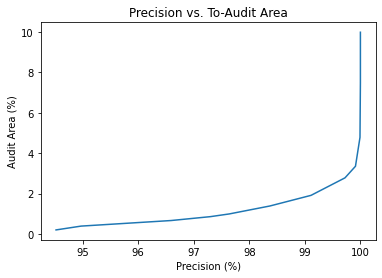

In [157]:
plt.plot(m_val['precision_L']*100, m_val['AA']*100)
plt.title('Precision vs. To-Audit Area')
plt.xlabel('Precision (%)')
plt.ylabel('Audit Area (%)')
if True:
    plt.savefig('figures/precision_AA_val.png', dpi=150, bbox_inches='tight')

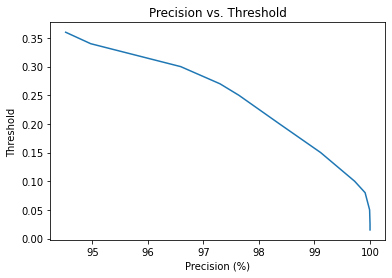

In [158]:
plt.plot(m_val['precision_L']*100, np.asarray(threshold_list_val))
plt.title('Precision vs. Threshold')
plt.xlabel('Precision (%)')
plt.ylabel('Threshold')
if True:
    plt.savefig('figures/precision_total_threshold_val.png', dpi=150, bbox_inches='tight')

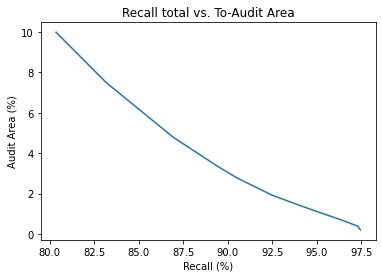

In [159]:
plt.plot(m_val['recall_Ltotal']*100, m_val['AA']*100)
plt.title('Recall total vs. To-Audit Area')
plt.xlabel('Recall (%)')
plt.ylabel('Audit Area (%)')
if True:
    plt.savefig('figures/recall_total_AA_val.png', dpi=150, bbox_inches='tight')

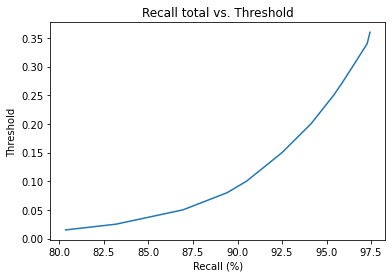

In [160]:
plt.plot(m_val['recall_Ltotal']*100, np.asarray(threshold_list_val))
plt.title('Recall total vs. Threshold')
plt.xlabel('Recall (%)')
plt.ylabel('Threshold')
if True:
    plt.savefig('figures/recall_total_threshold_val.png', dpi=150, bbox_inches='tight')

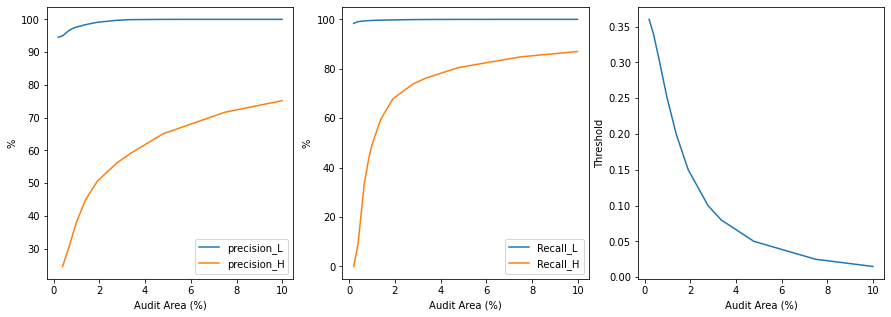

In [161]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figheight(5)
fig.set_figwidth(15)
ax1.plot(m_val['AA']*100, m_val['precision_L']*100, label="precision_L")
ax1.plot(m_val['AA']*100, m_val['precision_H']*100, label="precision_H")
ax1.legend(loc="lower right")
ax1.set_ylabel('%')
ax1.set_xlabel('Audit Area (%)')

ax2.plot(m_val['AA']*100, m_val['recall_L']*100, label="Recall_L")
ax2.plot(m_val['AA']*100, m_val['recall_H']*100, label="Recall_H")
ax2.legend(loc="lower right")
ax2.set_ylabel('%')
ax2.set_xlabel('Audit Area (%)')

ax3.plot(m_val['AA']*100, np.asarray(threshold_list_val), label="AA")
ax3.set_xlabel('Audit Area (%)')
ax3.set_ylabel('Threshold')

# if save_figures == True:
if True:
    plt.savefig('figures/recall_precision_AA_val.png', dpi=150, bbox_inches='tight')

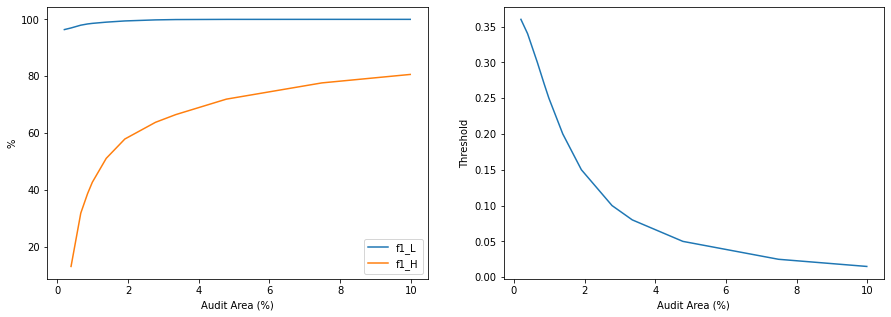

In [162]:
m_val['f1_L'] = 2*m_val['precision_L']*m_val['recall_L']/(m_val['precision_L']+m_val['recall_L'])
m_val['f1_H'] = 2*m_val['precision_H']*m_val['recall_H']/(m_val['precision_H']+m_val['recall_H'])

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(15)
ax1.plot(m_val['AA']*100, m_val['f1_L']*100, label="f1_L")
ax1.plot(m_val['AA']*100, m_val['f1_H']*100, label="f1_H")
ax1.legend(loc="lower right")
ax1.set_ylabel('%')
ax1.set_xlabel('Audit Area (%)')

ax2.plot(m_val['AA']*100, np.asarray(threshold_list_val), label="AA")
ax2.set_xlabel('Audit Area (%)')
ax2.set_ylabel('Threshold')

# if save_figures == True:
if True:
    plt.savefig('figures/f1_AA_val.png', dpi=150, bbox_inches='tight')

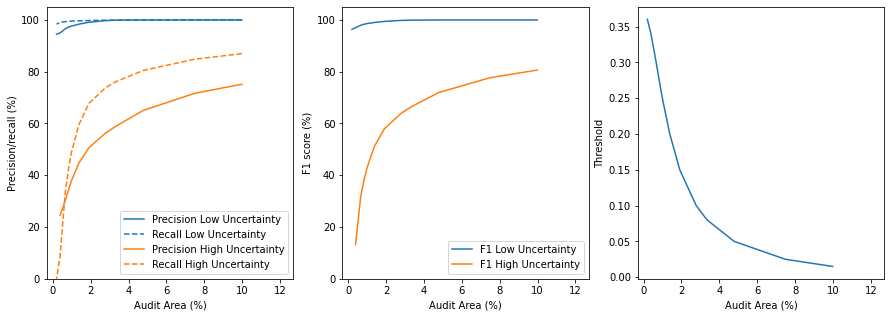

In [163]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figheight(5)
fig.set_figwidth(15)
ax1.plot(m_val['AA']*100, m_val['precision_L']*100, 'C0-', label="Precision Low Uncertainty")
ax1.plot(m_val['AA']*100, m_val['recall_L']*100, 'C0--', label="Recall Low Uncertainty")
ax1.plot(m_val['AA']*100, m_val['precision_H']*100, 'C1-', label="Precision High Uncertainty")
ax1.plot(m_val['AA']*100, m_val['recall_H']*100, 'C1--', label="Recall High Uncertainty")
ax1.legend(loc="lower right")
ax1.set_ylabel('Precision/recall (%)')
ax1.set_xlabel('Audit Area (%)')
ax1.set_ylim(ylim)
ax1.set_xlim(xlim)

ax2.plot(m_val['AA']*100, m_val['f1_L']*100, label="F1 Low Uncertainty")
ax2.plot(m_val['AA']*100, m_val['f1_H']*100, label="F1 High Uncertainty")
ax2.legend(loc="lower right")
ax2.set_ylabel('F1 score (%)')
ax2.set_xlabel('Audit Area (%)')
ax2.set_ylim(ylim)
ax2.set_xlim(xlim)

ax3.plot(m_val['AA']*100, np.asarray(threshold_list_val), label="AA")
ax3.set_xlabel('Audit Area (%)')
ax3.set_ylabel('Threshold')
ax3.set_xlim(xlim)

# if save_figures == True:
if True:
    plt.savefig('figures/recall_precision_AA_val.png', dpi=150, bbox_inches='tight')